# March Madness Results 

The NCAA Tournament results is the only dataset that does not require cleaning since we got it from Kaggle, so let us start with that.

In [1174]:
import pandas as pd

df_results = pd.read_csv("march_madness_results.csv")
df_results["LSEED"] = df_results["LSEED"].astype("int") # Do not know why this happend.
df_results.head()

,YEAR,ROUND,WSEED,WTEAM,WSCORE,LSEED,LTEAM,LSCORE
0,2021,6,1,Baylor,86,1,Gonzaga,70
1,2021,5,1,Gonzaga,93,11,UCLA,90
2,2021,5,1,Baylor,78,2,Houston,59
3,2021,4,2,Houston,67,12,Oregon State,61
4,2021,4,1,Baylor,81,3,Arkansas,72


All of the column names are self-explanatory except the Round column. Here is a quick description.
- 0 indicates a First Four Game (Games played before the tournament has started)
- 1 is the Round of 64
- 2 is the Round of 32
- 3 is the Round of 16. Also known as "Sweet Sixteen" or Regional Semis.
- 4 is the Round of 8. Also known as "Elite 8" or Regional Finals.
- 5 is the Final Four
- 6 is the National Championship

When filling out a bracket, it is usually logical to have the higher seed win, but that is not the case. The NCAA coins the term "upset" when a lower seeded team beats their opponent such that the difference between the seeds is at least 5. For example, in 2021, 11 seed Syracuse defeating 6 seed San Diego State is an upset while in 2018, 11 seed Loyola Chicago defeating 9 seed Kansas State is not. First, let us create a column to denote upsets. Then we will split them.

In [1317]:
df_results["UPSET"] = df_results["WSEED"] - df_results["LSEED"] > 4
df_upsets = df_results[df_results["UPSET"] == True]
df_non_upsets = df_results[df_results["UPSET"] == False]

df_upsets.head()

,YEAR,ROUND,WSEED,WTEAM,WSCORE,LSEED,LTEAM,LSCORE,UPSET
5,2021,4,11,UCLA,51,1,Michigan,49,True
11,2021,3,11,UCLA,88,2,Alabama,78,True
16,2021,2,11,Syracuse,75,3,West Virginia,72,True
17,2021,2,12,Oregon State,80,4,Oklahoma State,70,True
18,2021,2,8,Loyola (Ill.),71,1,Illinois,58,True


In [512]:
df_non_upsets.head()

,YEAR,ROUND,WSEED,WTEAM,WSCORE,LSEED,LTEAM,LSCORE,UPSET
0,2021,6,1,Baylor,86,1,Gonzaga,70,False
1,2021,5,1,Gonzaga,93,11,UCLA,90,False
2,2021,5,1,Baylor,78,2,Houston,59,False
3,2021,4,2,Houston,67,12,Oregon State,61,False
4,2021,4,1,Baylor,81,3,Arkansas,72,False


The way we are going to do our EDA will be split into two parts. The first part will be analyzing on average the upsets while the second will be analyzing over the years. For each analysis we will have a generally speaking conclusion and a trend conclusion respectively. After all the necessary analysis, we will take each concluding sentence into creating the perfect model.

## The Upset Scope

In [513]:
upsets_each_year = df_upsets.groupby("YEAR")["UPSET"].count()

### The Average Upset

Let us first use a histogram to visualize the count and frequency of total upsets per year.

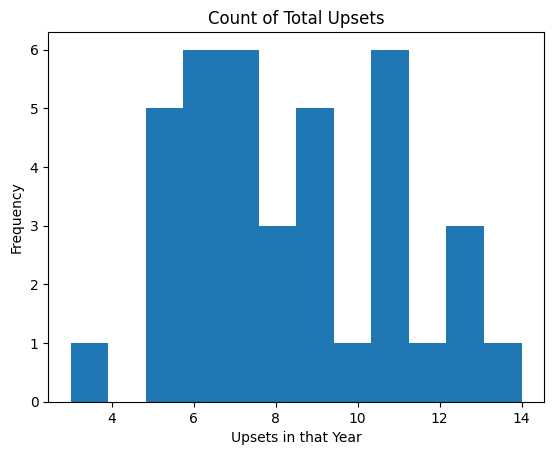

In [1109]:
import matplotlib.pyplot as plt

plt.hist(upsets_each_year, bins = 12)
plt.xlabel("Upsets in that Year")
plt.ylabel("Frequency")
plt.title("Count of Total Upsets")
plt.show()

This looks a little odd (pun intended). There are a lot more times where there were an odd number of upsets than even.

In [515]:
even_count = 0
odd_count = 0

for i in upsets_each_year:
    if i % 2 == 0:
        even_count += 1
    else:
        odd_count += 1
        
print("Odd-numbered upsets:", odd_count)
print("Even-numbered upsets:", even_count)
print(F"That is a {odd_count - even_count} count difference!")

Odd-numbered upsets: 26
Even-numbered upsets: 12
That is a 14 count difference!


We will set that aside for now. Let us look at all the necessary statistics and check for outliers.

In [516]:
x = upsets_each_year.describe()
x

count    38.000000
mean      8.315789
std       2.781262
min       3.000000
25%       6.000000
50%       8.000000
75%      11.000000
max      14.000000
Name: UPSET, dtype: float64

Using IQR, outliers are anything below -1.5 and above 18.5. We seem to have none here.


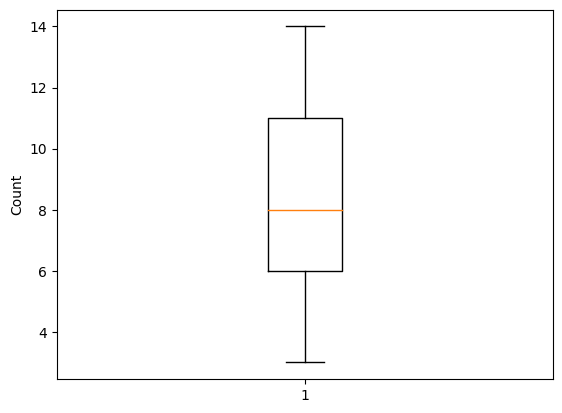

In [517]:
# Using IQR 
iqr = x['75%'] - x['25%']
out_below = x['25%'] - (1.5 * iqr)
out_above = x['75%'] + (1.5 * iqr)
print(F"Using IQR, outliers are anything below {out_below} and above {out_above}. We seem to have none here.")

# But let us use a boxplot just in case.
plt.boxplot(upsets_each_year)
plt.ylabel("Count")
plt.show()

In [518]:
# Using Mean and Standard Deviation
out_bel = x['mean'] - (3 * x['std'])
out_abo = x['mean'] + (3 * x['std'])
print(F"Using Mean, outliers are anything below {out_bel} and above {out_abo}. We seem to have none here.")

Using Mean, outliers are anything below -0.027997236881217802 and above 16.659576184249637. We seem to have none here.


**From this, we should pick around 6-10 upsets, but due to the 'odd' nature of the number of upsets, we should either pick 7 or 9 upsets, but if we are really spicy, pick 11. In the off-chance we think we should have an even number of upsets, we shall pick 6.**

### Upsets over the Years

In addition to finding more analyis in which investigating over the years is better suited, let us also try to challenge the conculsion we have just made. We can check the 'odd' situation real quick.

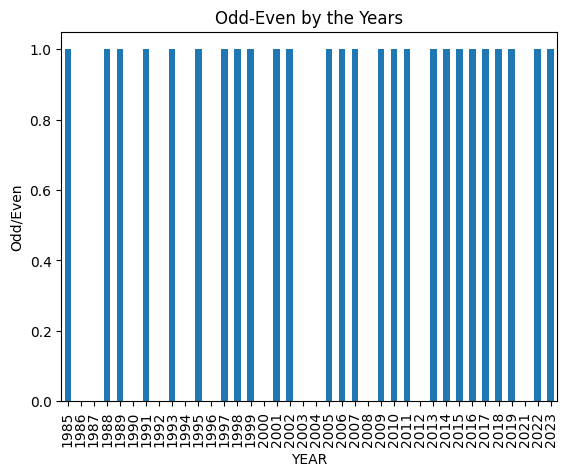

In [519]:
o_e = upsets_each_year % 2
o_e.plot(kind = 'bar', title = 'Odd-Even by the Years')
plt.ylabel("Odd/Even")
plt.show()

We cannot find a pattern in the above graph, so the 'odd-even' theory will stand. Now let us get back to our year-to-year analysis.

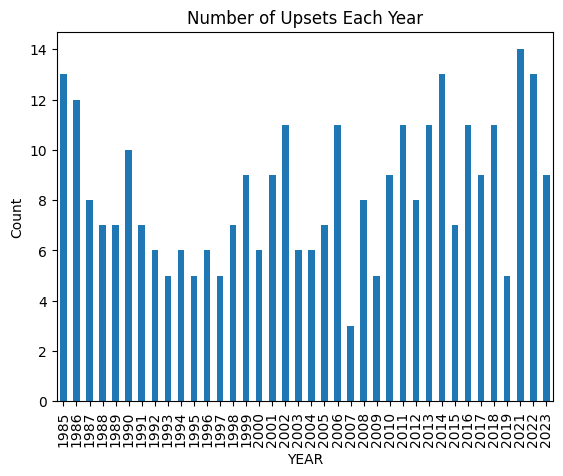

In [520]:
upsets_each_year.plot(kind = "bar", title = "Number of Upsets Each Year")
plt.ylabel("Count")
plt.show()

It seems like 2021 had the most upsets while in 2007, contenders seemed like they were more well prepared for the big dance. However, this is a little misleading. The matchups for Round 2 are completely dependent on the results of Round 1, so you can have more upset opportunities in Round 2 if there were more upsets in Round 1.

For example, suppose we have a 3-seed vs 14-seed matchup, and the 3-seed won. Their next opponent would be the 6-seed or the 11-seed. If the 6-seed won, then we would have a 3-seed vs. 6-seed matchup, hence no upset opportunity. On the other hand, if the 11-seed won, then we would have a 3-seed vs 11-seed matchup, hence an upset opportunity.

So, let us see the upset rate per year. To do this we will create a dataframe to contain only games with upset opportunities. Then, we can use our USPET column that we created to see the results.

In [521]:
c1 = df_results["WSEED"] - df_results["LSEED"] > 4
c2 = df_results["LSEED"] - df_results["WSEED"] > 4
df_upset_potential = df_results[c1 | c2]

df_upset_potential.head()

,YEAR,ROUND,WSEED,WTEAM,WSCORE,LSEED,LTEAM,LSCORE,UPSET
1,2021,5,1,Gonzaga,93,11,UCLA,90,False
3,2021,4,2,Houston,67,12,Oregon State,61,False
5,2021,4,11,UCLA,51,1,Michigan,49,True
6,2021,4,1,Gonzaga,85,6,Southern California,66,False
7,2021,3,2,Houston,62,11,Syracuse,46,False


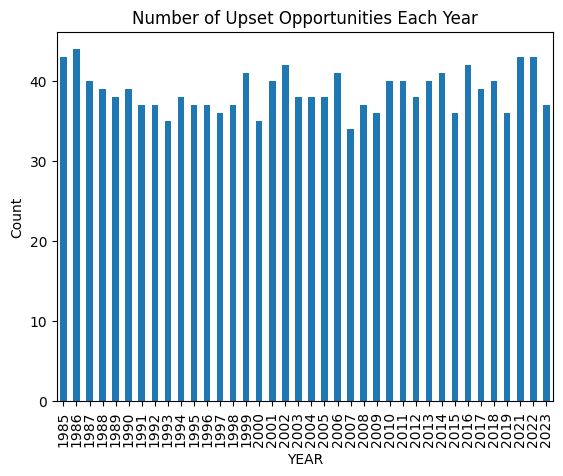

In [522]:
upset_oppos_each_year = df_upset_potential.groupby("YEAR")["UPSET"].count()
upset_oppos_each_year.plot(kind = "bar", title = "Number of Upset Opportunities Each Year")
plt.ylabel("Count")
plt.show()

 **Note:** In the first round, you have the 1-6 seeds versus the 16-11 seeds respectively for a total of 6 opportunites per each of the 4 regions, so in total, 24 matches have upset potential hre. In the second round, we have the 1/16 seed vs the 8/9 seed along with the 2/7 seed vs the 10/15 seed as guaranteed upset potential, so at least 8 games in the second round have upset potential. So a more accurate representation would be to subtract 32 from each year.

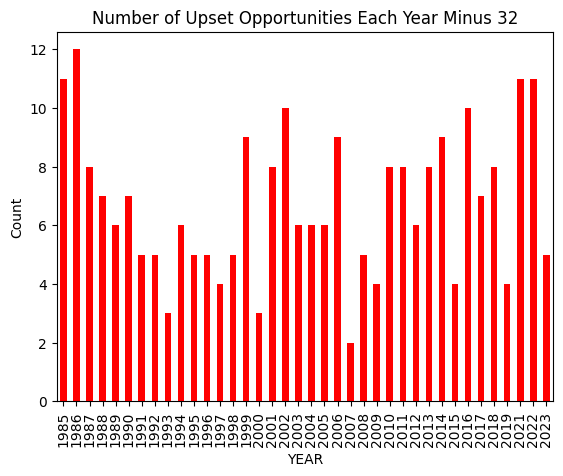

In [523]:
upset_oppos_each_year_minus = df_upset_potential.groupby("YEAR")["UPSET"].count() - 32
upset_oppos_each_year_minus.plot(kind = "bar", title = "Number of Upset Opportunities Each Year Minus 32", color = 'red')
plt.ylabel("Count")
plt.show()

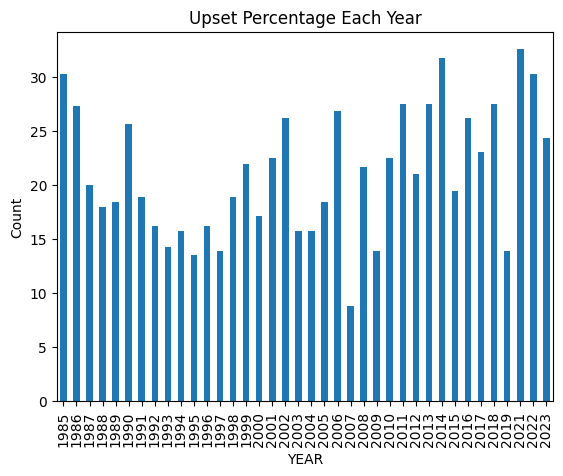

In [524]:
upset_percentage = upsets_each_year * 100 / upset_oppos_each_year
upset_percentage.plot(kind = "bar", title = "Upset Percentage Each Year")
plt.ylabel("Count")
plt.show()

Furthermore, if we look at how many possible upsets that do not happen each year, there seems to be a common trend.

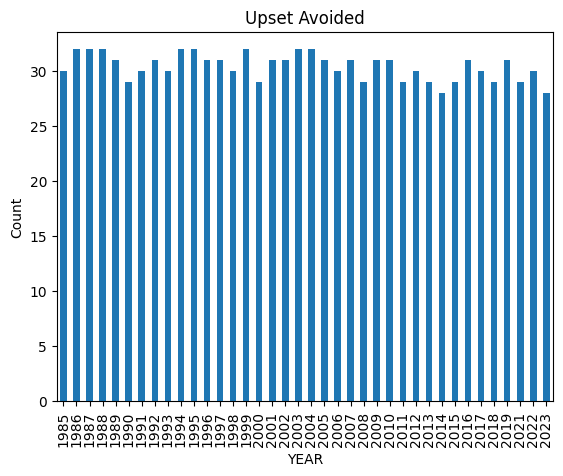

In [525]:
upsets_not_happening = upset_oppos_each_year - upsets_each_year
upsets_not_happening.plot(kind = "bar", title = "Upset Avoided")
plt.ylabel("Count")
plt.show()

**So I guess we can say for certain that we should have around 28-32 upset-potential games that do not result in one.**

## Round-by-Round EDA

Let us begin by breaking down upsets round by round. To make things easier, I have created a DataFrame for each round.

In [526]:
df_round_0 = df_results[df_results["ROUND"] == 0]
df_round_1 = df_results[df_results["ROUND"] == 1]
df_round_2 = df_results[df_results["ROUND"] == 2]
df_round_3 = df_results[df_results["ROUND"] == 3]
df_round_4 = df_results[df_results["ROUND"] == 4]
df_round_5 = df_results[df_results["ROUND"] == 5]
df_round_6 = df_results[df_results["ROUND"] == 6]

### Round 0

No upsets here, nor anything real interesting. There are times where a team compteting in Round 0 made it all the way to the Final Four, but we will discuss that later.

In [527]:
df_round_0.head()

,YEAR,ROUND,WSEED,WTEAM,WSCORE,LSEED,LTEAM,LSCORE,UPSET
62,2021,0,16,Norfolk State,54,16,Appalachian State,53,False
63,2021,0,11,Drake,53,11,Wichita State,52,False
64,2021,0,16,Texas Southern,60,16,Mount St. Mary's,52,False
65,2021,0,11,UCLA,86,11,Michigan State,80,False
129,2019,0,11,Belmont,81,11,Temple,70,False


### Round 1

From above, we only have 24 upset opportunities in the Round of 64.

In [902]:
c1 = df_round_1["WSEED"] - df_round_1["LSEED"] > 4
c2 = df_round_1["LSEED"] - df_round_1["WSEED"] > 4

df_round_1_upsets = df_round_1[c1]
df_round_1_upset_avoided = df_round_1[c2]
df_round_1_non_upsets = df_round_1[~c1 & ~c2]

#### Scope

As usual, we start with the Round 1 Scope

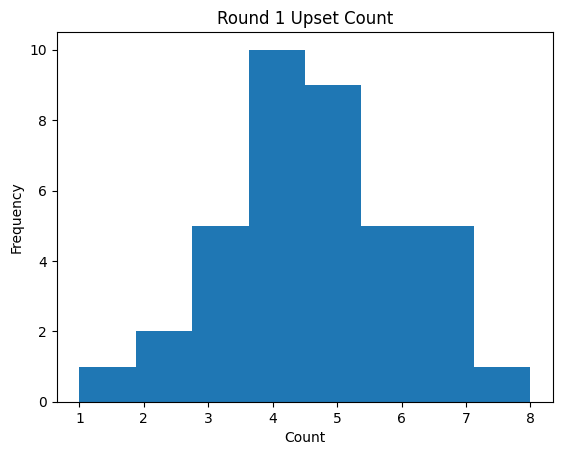

In [529]:
r1_upsets_per_yr = df_round_1_upsets.groupby("YEAR")["UPSET"].count()
plt.hist(r1_upsets_per_yr, bins = 8)
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.title("Round 1 Upset Count")
plt.show()

So it looks we have a roughly normal distribution centered at around 4. Let us look at more statistics while checking for outliers (which there should not be any).

In [530]:
x = r1_upsets_per_yr.describe()
x

count    38.000000
mean      4.684211
std       1.595691
min       1.000000
25%       4.000000
50%       5.000000
75%       6.000000
max       8.000000
Name: UPSET, dtype: float64

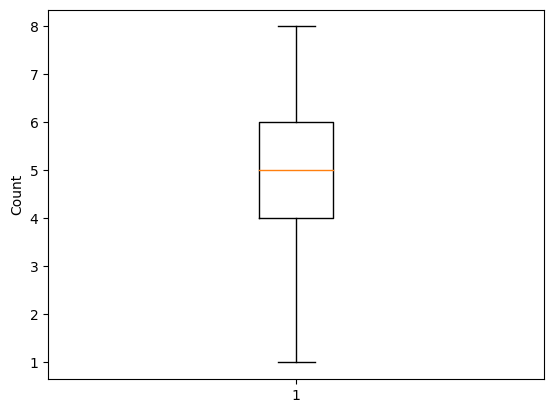

In [531]:
plt.boxplot(r1_upsets_per_yr)
plt.ylabel("Count")
plt.show()

We have to disect this a little more. Out of the total upsets, how many have been committed by 11 seeds? 12 seeds? 13 seeds? etc. More accurately, how often does an upset happen per seed? This is most likely a good indicator in predicting these upset potential games, but you never know. For now, let us get our simple answer.

In [532]:
x = df_round_1_upsets.groupby(["YEAR", "WSEED"])["UPSET"].count().to_frame()
r1_upset_count_by_year = x.pivot_table(values = "UPSET", index = "YEAR", columns = "WSEED", fill_value = 0)
r1_upset_count_by_year.head()

WSEED,11,12,13,14,15,16
YEAR,,,,,,
1985,3,1,1,0,0,0
1986,1,1,0,2,0,0
1987,0,1,2,1,0,0
1988,1,0,1,1,0,0
1989,4,1,1,1,0,0


The DataFrame above will be very useful for when we examine the year-by-year basis. For now, let us look at the histograms for these seeds.

In [533]:
r1_upset_count_by_year.describe()

WSEED,11,12,13,14,15,16
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,1.526316,1.394737,0.842105,0.578947,0.289474,0.052632
std,0.979157,0.916500,0.637831,0.642275,0.515065,0.226294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000,0.750000,0.000000
max,4.000000,3.000000,2.000000,2.000000,2.000000,1.000000


In [534]:
r1_upset_count_by_year.cumsum().iloc[-1]

WSEED
11    58
12    53
13    32
14    22
15    11
16     2
Name: 2023, dtype: int64

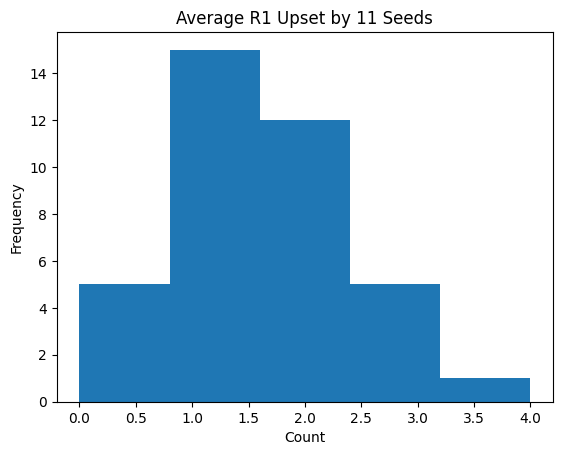

In [535]:
r1_upset_count_by_year[11].plot(kind = 'hist', bins = 5)
plt.title("Average R1 Upset by 11 Seeds")
plt.xlabel("Count")
plt.show()
# Note that there are 5 bars, and the count goes from 0 to 4

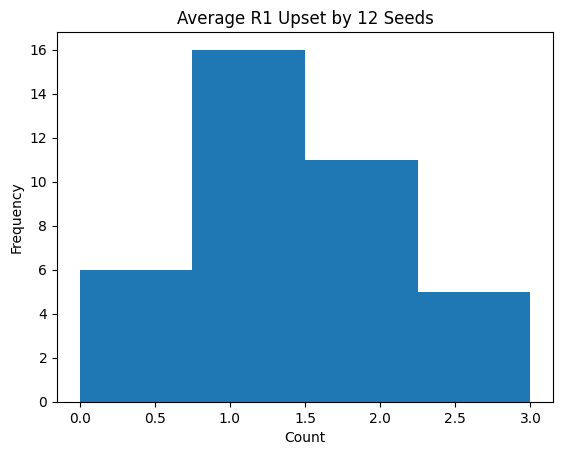

In [536]:
r1_upset_count_by_year[12].plot(kind = 'hist', bins = 4)
plt.title("Average R1 Upset by 12 Seeds")
plt.xlabel("Count")
plt.show()

The 11 and 12 seeds are extremely similar. One, the amount of upsets that they create are around the same. Their graphs look very much alike. In most years, they commit 1 upsets while in other years, they commit 2. In a few situations, they either commit 0 or 3 upsets. The only difference is that the 12 seeds never completely upsetted the 5 seeds. Now how about the 13 and 14 seeds?

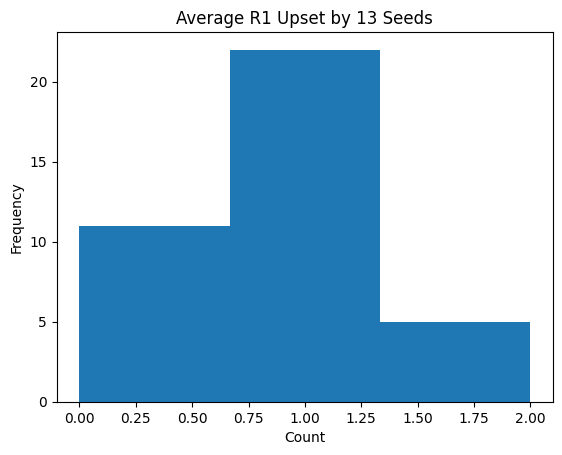

In [537]:
r1_upset_count_by_year[13].plot(kind = 'hist', bins = 3)
plt.title("Average R1 Upset by 13 Seeds")
plt.xlabel("Count")
plt.show()

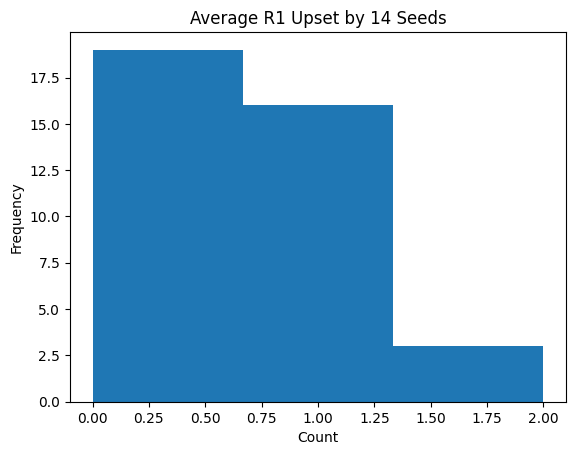

In [538]:
r1_upset_count_by_year[14].plot(kind = 'hist', bins = 3)
plt.title("Average R1 Upset by 14 Seeds")
plt.xlabel("Count")
plt.show()

Right off the bat, there is quite a difference between 13 and 14 seed upsets, but there is a huge drop from the number of 12 seed upsets to the number of 13 seed upsets. Their distributions are also different from 11/12 as well as between each other. While you can most likely call a 13-4 upset, you can only call one, and you should probably never call more than 2. On the other hand, we need to think more if we want our bracket to have a 13-4 upset or not. Now onto the 15 seed upsets.

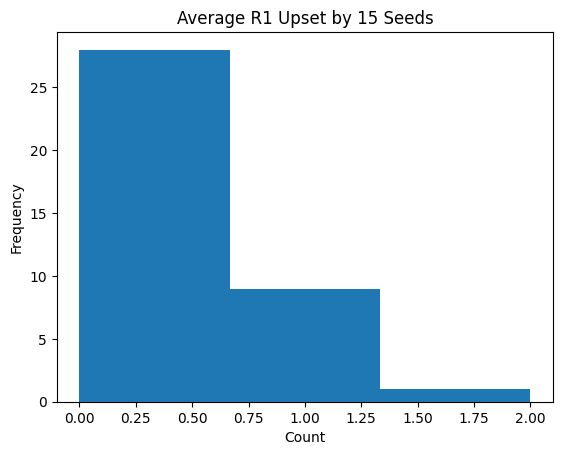

In [539]:
r1_upset_count_by_year[15].plot(kind = 'hist', bins = 3)
plt.title("Average R1 Upset by 15 Seeds")
plt.xlabel("Count")
plt.show()

I did not show the 16 seed graph since there are only two of them. Again, we see another drop off between 14/3 upsets and 15/2. We should most likely not pick this upset, but trends say otherwise. More on this in a bit.

**We should definitely have around 3-6 upsets. We should have at least 1 upset from the 11, 12, and maybe the 13 seed. The rest should be either another 11 and/or 12 upset or a 13, 14 and/or 15 upset.**

#### Over the Years

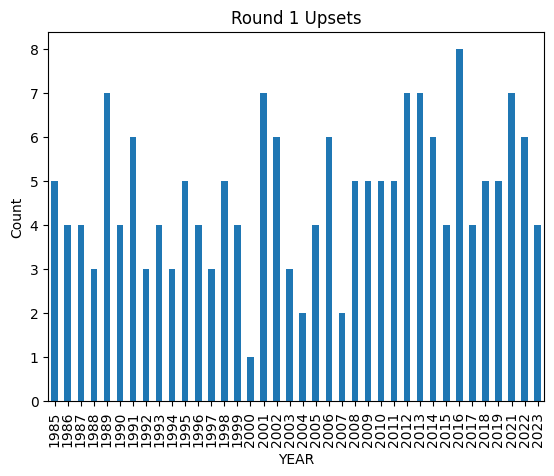

In [730]:
r1_upsets_per_yr.plot(kind = 'bar', title = 'Round 1 Upsets')
plt.ylabel("Count")
plt.show()

Now this does not tell us much, what we want to know is, what percentage of total upsets per year happen in the first round. Without seeing the graph, it should be predictable to say that it should be more than half. However, there are some cases that say otherwise.

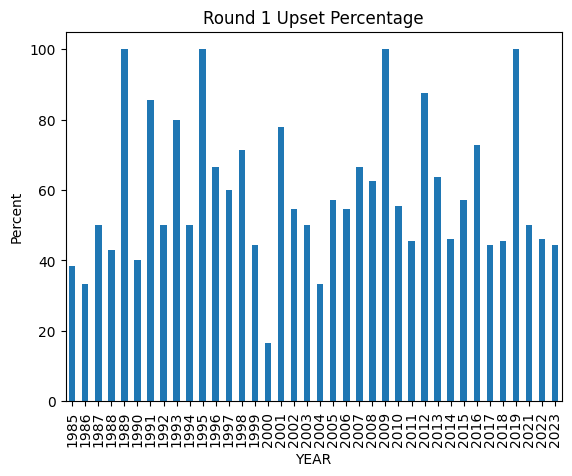

In [541]:
r1_upset_percentage = r1_upsets_per_yr * 100 / upsets_each_year
r1_upset_percentage.plot(kind = 'bar', title = 'Round 1 Upset Percentage')
plt.ylabel("Percent")
plt.show()

So does the number of upsets in the first round correspond to the total amount of upsets in that year? Let us use a scatterplot.

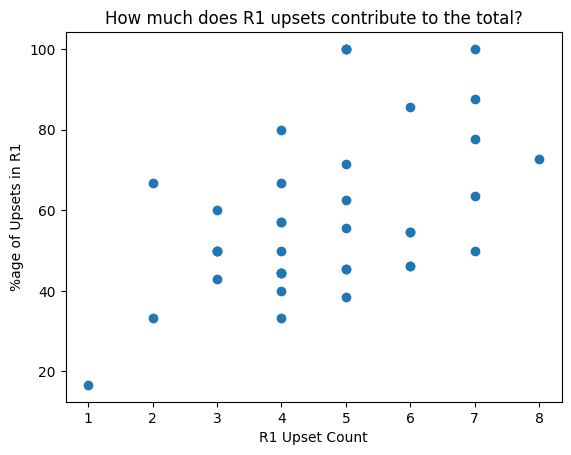

In [542]:
plt.scatter(r1_upsets_per_yr, r1_upset_percentage)
plt.title("How much does R1 upsets contribute to the total?")
plt.xlabel("R1 Upset Count")
plt.ylabel("%age of Upsets in R1")
plt.show()

So obviously there is a positive and somewhat linear relationship between R1 Upset Count and Percentage, but one key thing to look at is that there are only 28 points in this graph which means we have repeats. In the meantime, let us go back to our DataFrame that I mentioned earlier.

In [543]:
r1_upset_count_by_year.tail(3)

WSEED,11,12,13,14,15,16
YEAR,,,,,,
2021,2,1,2,1,1,0
2022,3,2,0,0,1,0
2023,1,0,1,0,1,1


We can use a stacked bar graph to look at how many upsets each seed committed in Round 1.

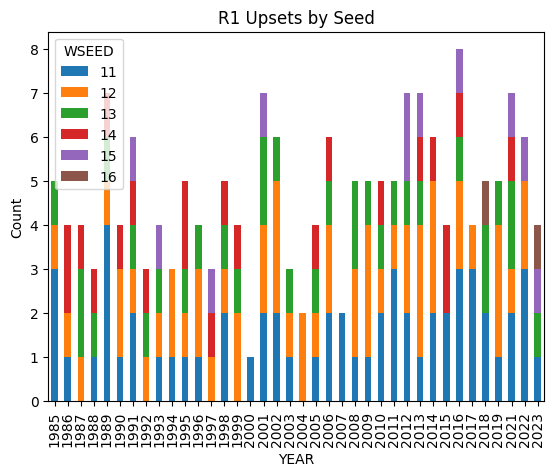

In [544]:
r1_upset_count_by_year.plot(kind = 'bar', stacked = True, title = "R1 Upsets by Seed")
plt.ylabel("Count")
plt.show()

As for the 11 seeds, we seem to have a trend. Here is the close up.

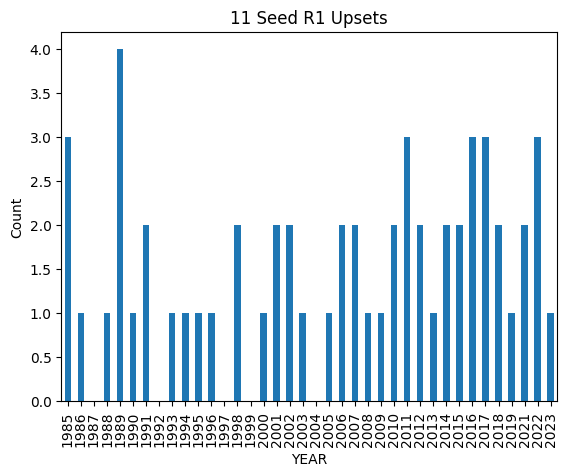

In [545]:
r1_upset_count_by_year[11].plot(kind = 'bar', title = "11 Seed R1 Upsets")
plt.ylabel("Count")
plt.show()

From 2009 to 2013, we have this bell shaped curve, and it roughly repeats this patten over the years. In 2023, we seem to hit the low point in 11/6 upsets, so we may consider 2 upsets for 2024. And now for the rest of the seeds.

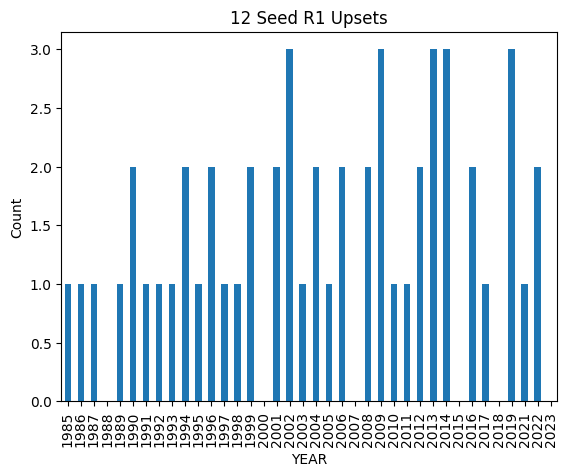

In [546]:
r1_upset_count_by_year[12].plot(kind = 'bar', title = "12 Seed R1 Upsets")
plt.ylabel("Count")
plt.show()

No pattern, no trend, the number of upsets by 12 seeds should depend on other factors. It is fairly safe to say that we can have 1 upset however.

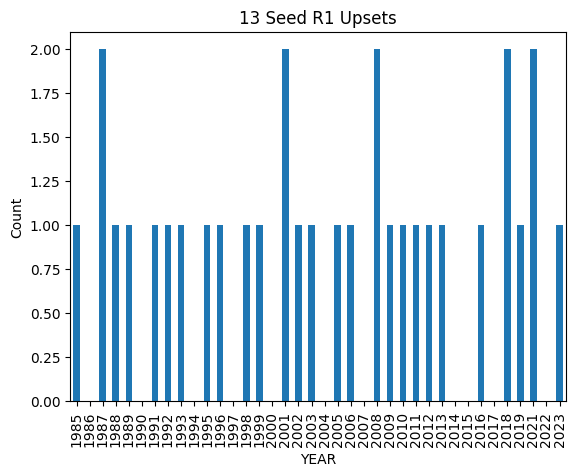

In [547]:
r1_upset_count_by_year[13].plot(kind = 'bar', title = "13 Seed R1 Upsets")
plt.ylabel("Count")
plt.show()

We have more consistent results here than the 12 seed. We are probably past the point where it will be a while when multiple 13/4 upsets happen, but we can take one and leave it. 

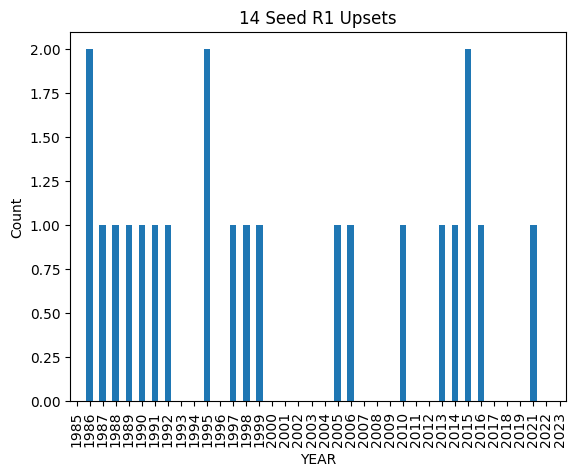

In [548]:
r1_upset_count_by_year[14].plot(kind = 'bar', title = "14 Seed R1 Upsets")
plt.ylabel("Count")
plt.show()

Now this is where things get tough. Again, no pattern or trend, and we must rely on other factors.

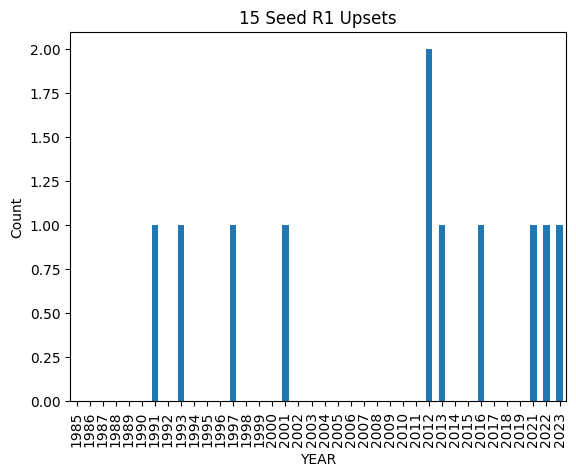

In [549]:
r1_upset_count_by_year[15].plot(kind = 'bar', title = "15 Seed R1 Upsets")
plt.ylabel("Count")
plt.show()

We have something finally. For the past three years, we recorded a 15 seed upset. Should 2024 continue this? Signs point to yes!

**Picking upsets really depends on the 11 seeds usually and the 15 seeds just recently. Plan accordingly.**

### Round 2

In [550]:
c1 = df_round_2["WSEED"] - df_round_2["LSEED"] > 4
c2 = df_round_2["LSEED"] - df_round_2["WSEED"] > 4

df_round_2_upsets = df_round_2[c1]
df_round_2_upset_avoided = df_round_2[c2]
df_round_2_upset_oppos = df_round_2[c1 | c2]
df_round_2_non_upsets = df_round_2[~c1 & ~c2]

#### Scope

In [551]:
r2_upsets_per_yr = df_round_2_upsets.groupby("YEAR")["UPSET"].count()

'''
Before we graph this, we must note that some years had all their upsets in the First Round.
We need to add those years to this Series in order to get the full Scope.
'''

# First we find all the years not present
lis = []
for i in range(r2_upsets_per_yr.index[0], r2_upsets_per_yr.index[-1]):
    if i == 2020: # Always skip 2020
        continue
    elif i not in r2_upsets_per_yr.index:
        lis.append(i)
 
# Make Dummy DataFrame with indices the missing years and 0 as their value
a13 = pd.DataFrame([0 for j in range(len(lis))], index = lis, columns = ["UPSET"])

# Convert r2_upsets_per_yr to DataFrame real quick
r2_upsets_per_yr = r2_upsets_per_yr.to_frame()

# Append the two
r2_upsets_per_yr = pd.concat([r2_upsets_per_yr, a13])

# Switch Back to Series
r2_upsets_per_yr = r2_upsets_per_yr.squeeze()

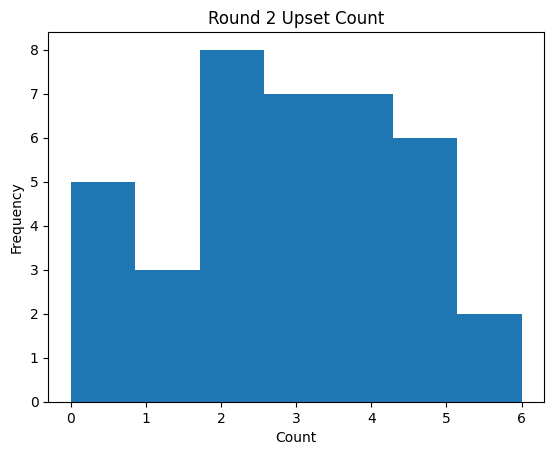

In [552]:
# Now let us plot it
plt.hist(r2_upsets_per_yr, bins = 7)
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.title("Round 2 Upset Count")
plt.show()

So we have somewhat equal frequencies centered around 3. Without the leftmost bar, the distribution is more normal, and we have a lot to consider in the second round.

First we must introduce the 1-8/9 upset opportunity as well as the 2-7/10 scenario. In the off-chance, we may also examine 16-8/9 matchups as well as 15-7/10. We can excuse the former since there have only been two 16-9 matchups in the 64-seed era both going the way of the 9th seed (though those games were close). Speaking of which, if we do have a 16-seed upset, should their opponent be the 9th seed and have them win against the 16 seed?

For now, let us first examine 1-8/9 matchups.

In [553]:
df_round_2_1st_seed_upset = df_round_2_upsets[df_round_2_upsets["LSEED"] == 1]
df_round_2_1st_seed_upset_avoided = df_round_2_upset_avoided[df_round_2_upset_avoided["WSEED"] == 1]
len(df_round_2_1st_seed_upset) / len(df_round_2_1st_seed_upset_avoided)

0.171875

There is only a 17% Upset Rate for 8/9 Seeds. It is not a lot, so we have a lot to disect here. First how often does the 8th seed upset the 1? The 9th seed? We need to know how many 1-8 matchups were there. So let us do that first. 

In [554]:
c1 = df_round_2_upset_oppos["WSEED"] == 1
c2 = df_round_2_upset_oppos["WSEED"] == 8
c3 = df_round_2_upset_oppos["WSEED"] == 9
c4 = df_round_2_upset_oppos["WSEED"] == 16
c5 = df_round_2_upset_oppos["LSEED"] == 1
c6 = df_round_2_upset_oppos["LSEED"] == 8
c7 = df_round_2_upset_oppos["LSEED"] == 9
c8 = df_round_2_upset_oppos["LSEED"] == 16

df_round_2_upset_oppos_1st_seed = df_round_2_upset_oppos[c1 | c2 | c3 | c4 | c5 | c6 | c7 | c8]
x = df_round_2_upset_oppos_1st_seed.groupby(["WSEED", "LSEED"])["UPSET"].count()
x

WSEED  LSEED
1      8        58
       9        70
8      1        16
9      1         6
       16        2
Name: UPSET, dtype: int64

First, let us note that not all possible combinations are here. We do not have (16, 8), (16, 9), or (8, 16). It is a good idea to first understand how often to we get these matchups.

In [555]:
df_r2_1_8_9_16 = x.to_frame().pivot_table(values = "UPSET", index = "WSEED", columns = "LSEED", fill_value = 0)
df_r2_1_8_9_16.loc[16] = [0, 0, 0, 0]

In [556]:
# We note that all values on the diagonals must be zero.
df_r2_1_8_9_16

LSEED,1,8,9,16
WSEED,,,,
1,0,58,70,0
8,16,0,0,0
9,6,0,0,2
16,0,0,0,0


What is actually pretty interesting here is that the 9th seed has won more than the 8th seed (76 vs. 74), but the 8th seed has been more successful against the 1st seed by a lot (16 vs. 6). If we simplified this to the percentage instead, we get this.

In [557]:
df_r2_1_8_9_16_percent = df_r2_1_8_9_16.copy()

for i in [1, 8, 9, 16]:
    for j in [1, 8, 9, 16]:
        if i == j or i + j == 17:
            continue
        df_r2_1_8_9_16_percent.loc[i, j] = df_r2_1_8_9_16.loc[i, j] / (df_r2_1_8_9_16.loc[i, j] + df_r2_1_8_9_16.loc[j, i])
            
df_r2_1_8_9_16_percent

/var/folders/fp/ldkzpcgs2vn05s1syqr7rjz40000gp/T/ipykernel_19308/2111680365.py:7: RuntimeWarning: invalid value encountered in long_scalars
  df_r2_1_8_9_16_percent.loc[i, j] = df_r2_1_8_9_16.loc[i, j] / (df_r2_1_8_9_16.loc[i, j] + df_r2_1_8_9_16.loc[j, i])


LSEED,1,8,9,16
WSEED,,,,
1,0.000000,0.783784,0.921053,0.0
8,0.216216,0.000000,0.000000,NaN
9,0.078947,0.000000,0.000000,1.0
16,0.000000,NaN,0.000000,0.0


The 8th seeds have a much better chance at upsetting the 1st seed than the 9th seed despite the higher success rate of 9th seeds over 8th seeds. Is it because the 8th seed often looks past their opponent just because they are higher seed or NCAA needs to do a better job in seeding these teams (I mean not like it matters since we expect this matchup to be at least equal if not leaning more towards the 8th seed). 

Let us also follow the same process for the 2/7/10/15 seeds.

In [558]:
d1 = df_round_2_upset_oppos["WSEED"] == 2
d2 = df_round_2_upset_oppos["WSEED"] == 7
d3 = df_round_2_upset_oppos["WSEED"] == 10
d4 = df_round_2_upset_oppos["WSEED"] == 15
d5 = df_round_2_upset_oppos["LSEED"] == 2
d6 = df_round_2_upset_oppos["LSEED"] == 7
d7 = df_round_2_upset_oppos["LSEED"] == 10
d8 = df_round_2_upset_oppos["LSEED"] == 15

df_round_2_upset_oppos_2nd_seed = df_round_2_upset_oppos[d1 | d2 | d3 | d4 | d5 | d6 | d7 | d8]
x = df_round_2_upset_oppos_2nd_seed.groupby(["WSEED", "LSEED"])["UPSET"].count()
x

WSEED  LSEED
2      7        60
       10       35
7      2        27
       15        2
10     2        19
       15        5
15     7         4
Name: UPSET, dtype: int64

In [559]:
# This time, we do not have a (15, 10) Pairing.
df_r2_2_7_10_15 = x.to_frame().pivot_table(values = "UPSET", index = "WSEED", columns = "LSEED", fill_value = 0)
df_r2_2_7_10_15

LSEED,2,7,10,15
WSEED,,,,
2,0,60,35,0
7,27,0,0,2
10,19,0,0,5
15,0,4,0,0


In [635]:
df_r2_2_7_10_15_percent = df_r2_2_7_10_15.copy()

for i in [2, 7, 10, 15]:
    for j in [2, 7, 10, 15]:
        if i == j or i + j == 17:
            continue
        df_r2_2_7_10_15_percent.loc[i, j] = df_r2_2_7_10_15.loc[i, j] / (df_r2_2_7_10_15.loc[i, j] + df_r2_2_7_10_15.loc[j, i])
            
df_r2_2_7_10_15_percent

LSEED,2,7,10,15
WSEED,,,,
2,0.000000,0.689655,0.648148,0.000000
7,0.310345,0.000000,0.000000,0.333333
10,0.351852,0.000000,0.000000,1.000000
15,0.000000,0.666667,0.000000,0.000000


Somehow, the 10th seed as a higher chance of upsetting the 2nd seed than the 7th seed. Weird. Also, the 15th seed as a better chance of upsetting the 7th seed than they do the 10th seed. In fact, the 10 always moves on when their opponent is the 15. 

Now for the other two, let us analyze this a different way. For example, by looking at the 3/6/11/14 matchup, we could end up with 3/6, 3/11, 6/14, or 11/14. Half of these are upset opportunities while the other half are not. Within the half which are not upset opportunities, the previous outcomes resulted in either no upsets (3/6) or both upsets (11/14). That is why we need to look at this together.

In [645]:
df_upset_3_to_14 = df_round_2_upset_oppos[~(c1 | c2 | c3 | c4 | c5 | c6 | c7 | c8 | d1 | d2 | d3 | d4 | d5 | d6 | d7 | d8)]
df_upset_3_to_14.head()

,YEAR,ROUND,WSEED,WTEAM,WSCORE,LSEED,LTEAM,LSCORE,UPSET
16,2021,2,11,Syracuse,75,3,West Virginia,72,True
17,2021,2,12,Oregon State,80,4,Oklahoma State,70,True
21,2021,2,5,Villanova,84,13,North Texas,61,False
29,2021,2,5,Creighton,72,13,Ohio,58,False
86,2019,2,4,Virginia Tech,67,12,Liberty,58,False


First, let us find how often each matchup occurs to get a better idea.

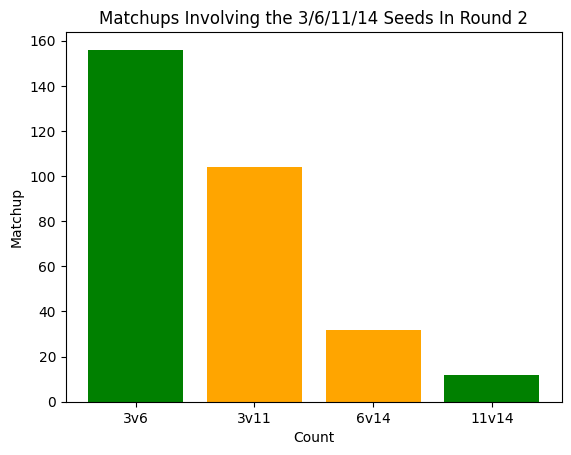

Upset Potential Matchups in R2 via 3/6/11/14 is 44.73684210526316 Percent.


In [711]:
# Start with the 3/6/11/14 matchup
df_3_6_11_14_matchups = pd.DataFrame()
l = [3, 6, 11, 14]
for i in l:
    df_3_6_11_14_matchups = pd.concat([df_3_6_11_14_matchups, df_round_2[df_round_2["WSEED"] == i]])
    df_3_6_11_14_matchups = pd.concat([df_3_6_11_14_matchups, df_round_2[df_round_2["LSEED"] == i]])

matchups_3_6_11_14 = {"3v6": 0, "3v11": 0, "6v14": 0, "11v14": 0}

for j in range(len(df_3_6_11_14_matchups)):
    lower = str(min(df_3_6_11_14_matchups.iloc[j, 2], df_3_6_11_14_matchups.iloc[j, 5]))
    upper = str(max(df_3_6_11_14_matchups.iloc[j, 2], df_3_6_11_14_matchups.iloc[j, 5]))
    s = lower + "v" + upper
    matchups_3_6_11_14[s] += 1

# The Orange denotes upset potential while the Green does not
key1 = list(matchups_3_6_11_14.keys())
val1 = list(matchups_3_6_11_14.values())

plt.bar(key1, val1, color = ['green', 'orange', 'orange', 'green'])
plt.xlabel("Count")
plt.ylabel("Matchup")
plt.title("Matchups Involving the 3/6/11/14 Seeds In Round 2")

plt.show()
print("Upset Potential Matchups in R2 via 3/6/11/14 is", (val1[1] + val1[2]) * 100 / len(df_3_6_11_14_matchups), "Percent.")

Text(0.5, 1.0, 'Matchups Involving the 3/6/11/14 Seeds In Round 2 Percentage')

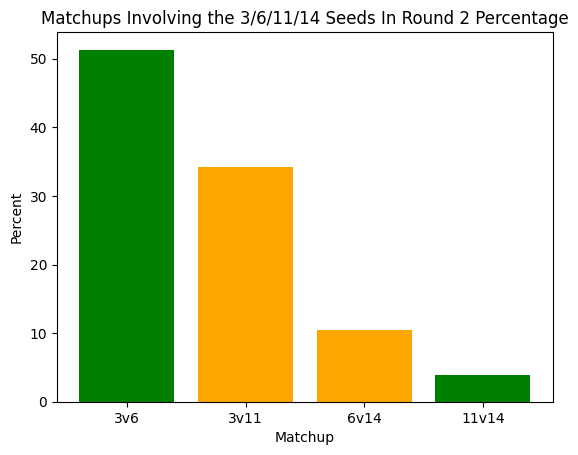

In [712]:
# Using Percentages
val1_per = [i * 100 / sum(val1) for i in val1]
plt.bar(key1, val1_per, color = ['green', 'orange', 'orange', 'green'])
plt.xlabel("Matchup")
plt.ylabel("Percent")
plt.title("Matchups Involving the 3/6/11/14 Seeds In Round 2 Percentage")

Then we find the upset rate between the two orange bars.

In [713]:
m = df_3_6_11_14_matchups["WSEED"] == 11
n = df_3_6_11_14_matchups["LSEED"] == 3
o = df_3_6_11_14_matchups["WSEED"] == 14
p = df_3_6_11_14_matchups["LSEED"] == 6
print("Upset rate between 3 and 11 is", len(df_3_6_11_14_matchups[m & n]) * 100 / val1[1], "Percent.")
print("Upset rate between 6 and 14 is", len(df_3_6_11_14_matchups[o & p]) * 100 / val1[2], "Percent.")

Upset rate between 3 and 11 is 38.46153846153846 Percent.
Upset rate between 6 and 14 is 12.5 Percent.


3v6 is the most common matchup in Round 2 involving these four seeds. We see a big drop off from that to 3v11 and another huge drop off from there to 6v14. There have been only a small amount 11v14 matchups. Focusing on the middle matchups, we do not see a whole lot of upsets. Let us repeat the process for the 4/5/12/13 matchups.

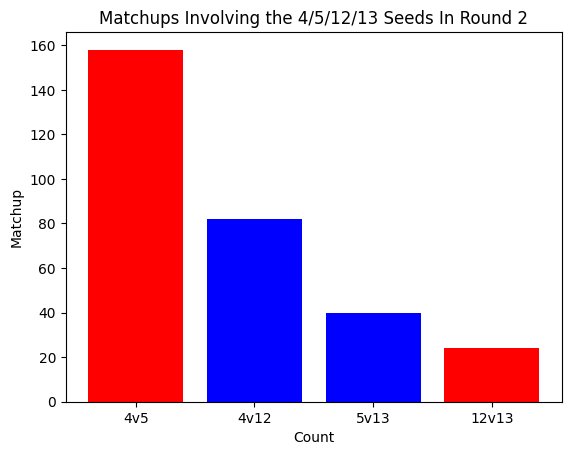

Upset Potential Matchups in R2 via 4/5/12/13 is 40.13157894736842 Percent.


In [714]:
df_4_5_12_13_matchups = pd.DataFrame()
l = [4, 5, 12, 13]
for i in l:
    df_4_5_12_13_matchups = pd.concat([df_4_5_12_13_matchups, df_round_2[df_round_2["WSEED"] == i]])
    df_4_5_12_13_matchups = pd.concat([df_4_5_12_13_matchups, df_round_2[df_round_2["LSEED"] == i]])

matchups_4_5_12_13 = {"4v5": 0, "4v12": 0, "5v13": 0, "12v13": 0}

for j in range(len(df_4_5_12_13_matchups)):
    lower = str(min(df_4_5_12_13_matchups.iloc[j, 2], df_4_5_12_13_matchups.iloc[j, 5]))
    upper = str(max(df_4_5_12_13_matchups.iloc[j, 2], df_4_5_12_13_matchups.iloc[j, 5]))
    s = lower + "v" + upper
    matchups_4_5_12_13[s] += 1

# The Blue denotes upset potential while the Red does not
key2 = list(matchups_4_5_12_13.keys())
val2 = list(matchups_4_5_12_13.values())

plt.bar(key2, val2, color = ['red', 'blue', 'blue', 'red'])
plt.xlabel("Count")
plt.ylabel("Matchup")
plt.title("Matchups Involving the 4/5/12/13 Seeds In Round 2")

plt.show()
print("Upset Potential Matchups in R2 via 4/5/12/13 is", (val2[1] + val2[2]) * 100 / len(df_4_5_12_13_matchups), "Percent.")

Text(0.5, 1.0, 'Matchups Involving the 4/5/12/13 Seeds In Round 2 Percentage')

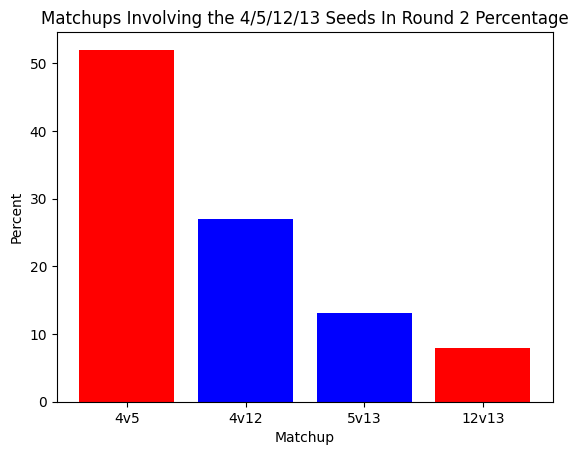

In [715]:
# Using Percentages
val2_per = [i * 100 / sum(val2) for i in val2]
plt.bar(key2, val2_per, color = ['red', 'blue', 'blue', 'red'])
plt.xlabel("Matchup")
plt.ylabel("Percent")
plt.title("Matchups Involving the 4/5/12/13 Seeds In Round 2 Percentage")

In [716]:
w = df_4_5_12_13_matchups["WSEED"] == 12
x = df_4_5_12_13_matchups["LSEED"] == 4
y = df_4_5_12_13_matchups["WSEED"] == 13
z = df_4_5_12_13_matchups["LSEED"] == 5
print("Upset rate between 4 and 12 is", len(df_4_5_12_13_matchups[w & x]) * 100 / val2[1], "Percent.")
print("Upset rate between 5 and 13 is", len(df_4_5_12_13_matchups[y & z]) * 100 / val2[2], "Percent.")

Upset rate between 4 and 12 is 31.70731707317073 Percent.
Upset rate between 5 and 13 is 15.0 Percent.


Let us also compare this to the previous matchup too.

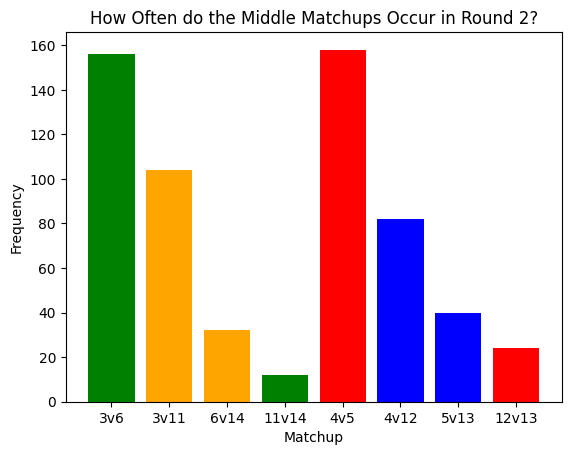

In [717]:
plt.bar(key1, val1, color = ['green', 'orange', 'orange', 'green'])
plt.bar(key2, val2, color = ['red', 'blue', 'blue', 'red'])
plt.xlabel("Matchup")
plt.ylabel("Frequency")
plt.title("How Often do the Middle Matchups Occur in Round 2?")
plt.show()

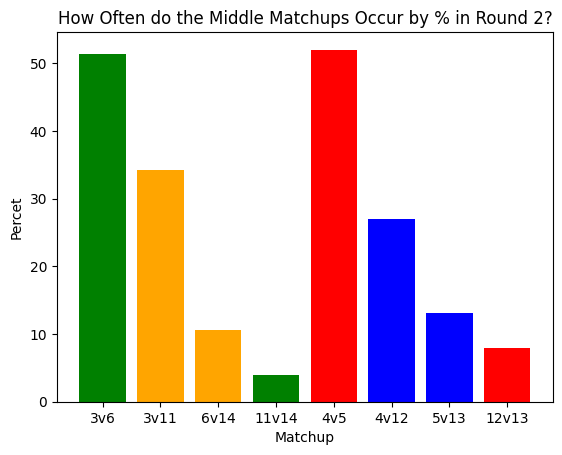

In [718]:
plt.bar(key1, val1_per, color = ['green', 'orange', 'orange', 'green'])
plt.bar(key2, val2_per, color = ['red', 'blue', 'blue', 'red'])
plt.xlabel("Matchup")
plt.ylabel("Percet")
plt.title("How Often do the Middle Matchups Occur by % in Round 2?")
plt.show()

So the matchups are actually quite even despite a noticable disparity between the second most common matchup. Looks like the 3v11 matchup is more popular than the 4v12 matchup, but the 5v13 and 12v13 matchups both outclass their counterparts.

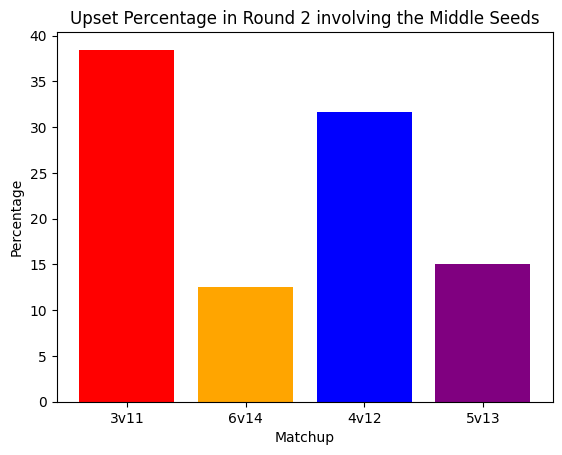

In [721]:
three_v_eleven = round(len(df_3_6_11_14_matchups[m & n]) * 100 / val1[1], 2)
six_v_fourteen = round(len(df_3_6_11_14_matchups[o & p]) * 100 / val1[2], 2)
four_v_twelve = round(len(df_4_5_12_13_matchups[w & x]) * 100 / val2[1], 2)
five_v_thirteen = round(len(df_4_5_12_13_matchups[y & z]) * 100 / val2[2], 2)

l = [three_v_eleven, six_v_fourteen, four_v_twelve, five_v_thirteen]
some_keys = ["3v11", "6v14", "4v12", "5v13"]

plt.bar(some_keys, l, color = ["red", "orange", "blue", "purple"])
plt.xlabel("Matchup")
plt.ylabel("Percentage")
plt.title("Upset Percentage in Round 2 involving the Middle Seeds")
plt.show()

We note above that there is an 8 seed difference between these matchups, yet they all have varying upset rate. It seems like there is a huger dropoff in win percentage between the 11 and 14 seed than there is the 3 and 6 seeeds.

**There is really nothing out of the ordinary other than the fact that 15 seeds have a better chance to upset the 7 seed than the 10. While the 3v11 and 4v12 matchups have an unusually high upset rate, it is really nothing to write home about.**

#### Over the Years in the Round of 32

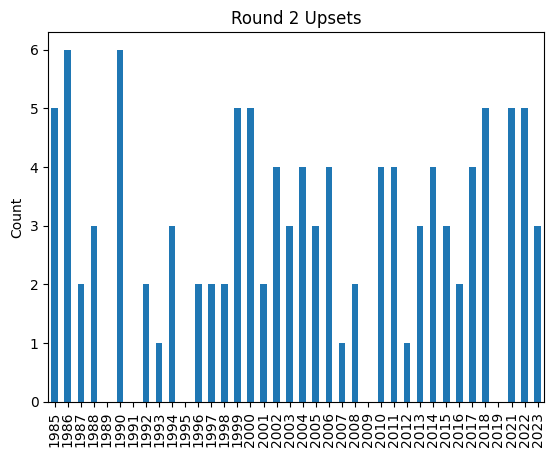

In [788]:
r2_upsets_per_yr.sort_index().plot(kind = 'bar', title = 'Round 2 Upsets')
plt.ylabel("Count")
plt.show()

Again, does not reaaly tell us much until we see the percentage instead.

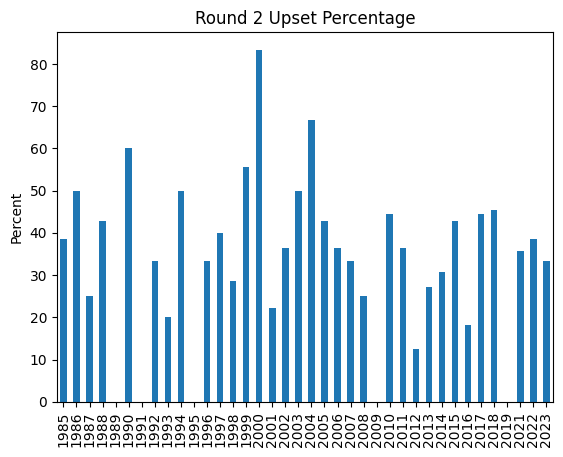

In [789]:
r2_upset_percentage = r2_upsets_per_yr * 100 / upsets_each_year
r2_upset_percentage.plot(kind = 'bar', title = 'Round 2 Upset Percentage')
plt.ylabel("Percent")
plt.show()

Now this looks a bit interesting. There is a lot of up and down trends over the years. Will a line graph confirm our suspicions?

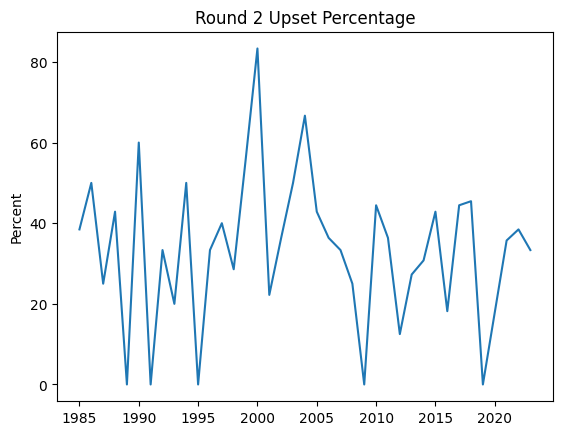

In [790]:
r2_upset_percentage.plot(kind = 'line', title = 'Round 2 Upset Percentage')
plt.ylabel("Percent")
plt.show()

Yes! It looks like it is trending downwards after hitting a peek.

Now for the seed analysis. We will split this into two graphs since graphing a stacked bar graph with 10 seeds is too much. We will split it into the 7/10 seeds first then the 11/16. The reason why is because we would also like to see if the first round upsetters continue their run, or they are stopped short.

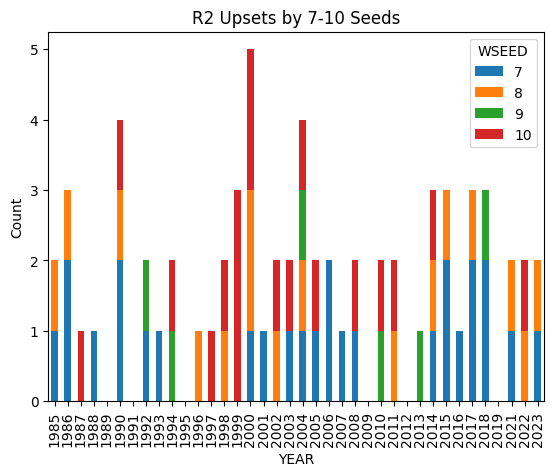

In [800]:
# Starting with the 7-10 seeds.
c1 = df_round_2_upsets["WSEED"] > 6
c2 = df_round_2_upsets["WSEED"] < 11
r2_7_10 = df_round_2_upsets[c1 & c2]
x = r2_7_10.groupby(["YEAR", "WSEED"])["UPSET"].count().to_frame()
r2_7_10_by_year = x.pivot_table(values = "UPSET", index = "YEAR", columns = "WSEED", fill_value = 0)

# Let us also account for missing years
for i in range(r2_7_10_by_year.index[0], r2_7_10_by_year.index[-1]):
    if i == 2020: # Always skip 2020
        continue
    elif i not in r2_7_10_by_year.index:
        r2_7_10_by_year.loc[i] = 0

r2_7_10_by_year.sort_index().plot(kind = 'bar', stacked = True, title = "R2 Upsets by 7-10 Seeds")
plt.ylabel("Count")
plt.show()

Another way to look at this is to analyze how often does the 1 and 2 seed get upsetted. In other words, we are not concerned who upsetted them.

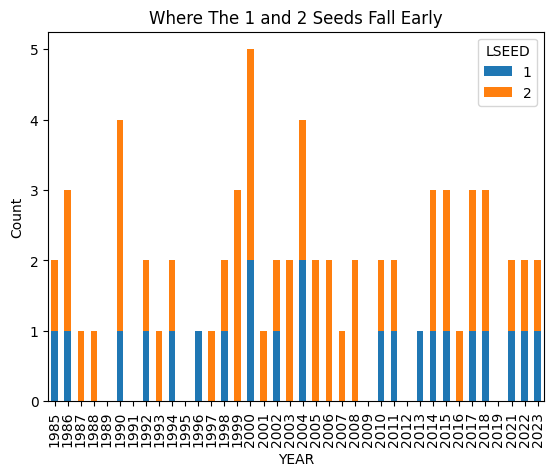

In [784]:
c11 = df_round_2_upsets["LSEED"] == 1
c12 = df_round_2_upsets["LSEED"] == 2
r2_1_2_upsetted = df_round_2_upsets[c11 | c12]
y = r2_1_2_upsetted.groupby(["YEAR", "LSEED"])["UPSET"].count().to_frame()
r2_1_2_upsetted_by_year = y.pivot_table(values = "UPSET", index = "YEAR", columns = "LSEED", fill_value = 0)

# Let us also account for missing years
for i in range(r2_1_2_upsetted_by_year.index[0], r2_1_2_upsetted_by_year.index[-1]):
    if i == 2020: # Always skip 2020
        continue
    elif i not in r2_1_2_upsetted_by_year.index:
        r2_1_2_upsetted_by_year.loc[i] = 0

r2_1_2_upsetted_by_year.sort_index().plot(kind = 'bar', stacked = True, title = "Where The 1 and 2 Seeds Fall Early")
plt.ylabel("Count")
plt.show()

Interesting. With the exception of the years where no 1 or 2 seed fell in the Second Round, there have been only two occurences where the 2nd seed avoided disaster. Upon looking at the missing data, we see that the Round 1 Upset Percentage is either 100% or absurdly high (Confirmed Below). As for the 1 Seed, with the exception of 2016 and the empty years, there have been a 1 seed upset since 2010. 

In [959]:
print(r1_upset_percentage[1989])
print(r1_upset_percentage[1991])
print(r1_upset_percentage[1995])
print(r1_upset_percentage[2009])
print(r1_upset_percentage[2012])
print(r1_upset_percentage[2019])

100.0
85.71428571428571
100.0
100.0
87.5
100.0


Now for the more interesting side. Do the upsetters continue their hot streak?

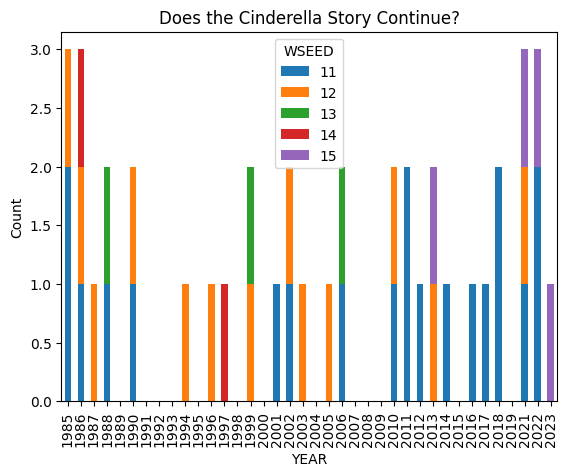

In [960]:
c13 = df_round_2_upsets["WSEED"] > 10
r2_11_16 = df_round_2_upsets[c13]
x1 = r2_11_16.groupby(["YEAR", "WSEED"])["UPSET"].count().to_frame()
r2_11_16_by_year = x1.pivot_table(values = "UPSET", index = "YEAR", columns = "WSEED", fill_value = 0)

# Let us also account for missing years
for i in range(r2_11_16_by_year.index[0], r2_11_16_by_year.index[-1]):
    if i == 2020: # Always skip 2020
        continue
    elif i not in r2_11_16_by_year.index:
        r2_11_16_by_year.loc[i] = 0

r2_11_16_by_year.sort_index().plot(kind = 'bar', stacked = True, title = "Does the Cinderella Story Continue?")
plt.ylabel("Count")
plt.show()

Recently, we see a lot of 11 seeds move on to the Sweet 16. As for the 12 seeds, their luck is pretty scattered. 13 and 14 seeds do not have much luck in the second round. The most surprising thing however is the 15 seeds. Since 2021, the 15 seed has moved on to the next round.

**Trends say we should have a 1 and 2 upset in the Second Round. We should also have an 11 seed move on as well as a 15 seed. At this point, that should be more than enough upsets since we really cannot trust the 12-14 seeds to do anything.**

Now unfortunately, when a lower seed commits an upset in the first round, their next round opponent puts them in their place...

/var/folders/fp/ldkzpcgs2vn05s1syqr7rjz40000gp/T/ipykernel_19308/3663915817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upset_continued["Pt Diff"] = df_round_2_upset_oppos["WSCORE"] - df_round_2_upset_oppos["LSCORE"]
/var/folders/fp/ldkzpcgs2vn05s1syqr7rjz40000gp/T/ipykernel_19308/3663915817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upset_continued["Seed in ?"] = df_upset_continued["WSEED"]
/var/folders/fp/ldkzpcgs2vn05s1syqr7rjz40000gp/T/ipykernel_19308/3663915817.py:8: SettingWithC

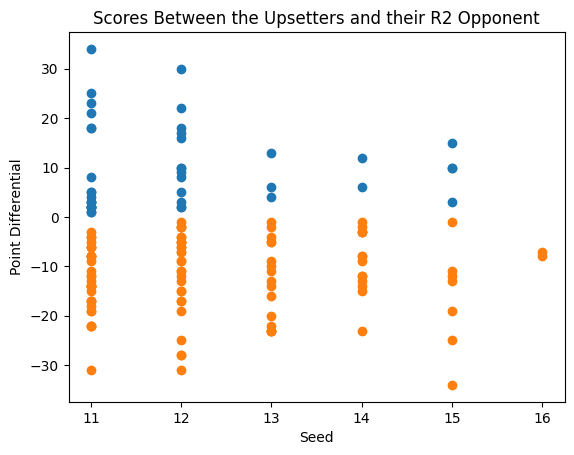

In [961]:
c1 = df_round_2_upset_oppos["WSEED"] > 10
c2 = df_round_2_upset_oppos["LSEED"] > 10
df_upset_continued = df_round_2_upset_oppos[c1]
df_upset_lost = df_round_2_upset_oppos[c2]

df_upset_continued["Pt Diff"] = df_round_2_upset_oppos["WSCORE"] - df_round_2_upset_oppos["LSCORE"]
df_upset_continued["Seed in ?"] = df_upset_continued["WSEED"]
df_upset_lost["Pt Diff"] = df_round_2_upset_oppos["LSCORE"] - df_round_2_upset_oppos["WSCORE"]
df_upset_lost["Seed in ?"] = df_upset_lost["LSEED"]

plt.scatter(x = df_upset_continued["WSEED"], y = df_upset_continued["Pt Diff"])
plt.scatter(x = df_upset_lost["LSEED"], y = df_upset_lost["Pt Diff"])
plt.title("Scores Between the Upsetters and their R2 Opponent")
plt.xlabel("Seed")
plt.ylabel("Point Differential")
plt.show()

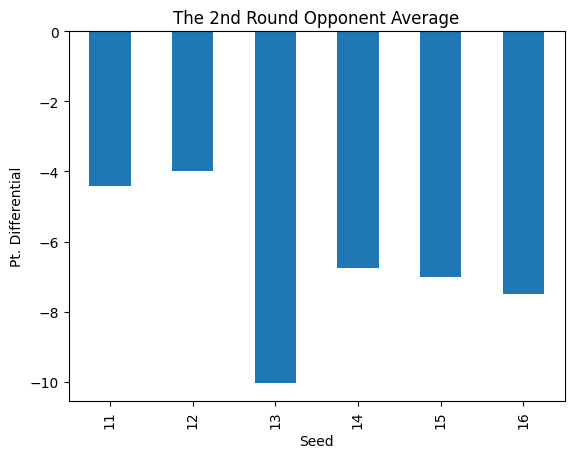

In [962]:
df21 = pd.concat([df_upset_continued, df_upset_lost])
m = df21.groupby("Seed in ?")["Pt Diff"].mean()
m.plot(kind = 'bar', title = "The 2nd Round Opponent Average")
plt.xlabel("Seed")
plt.ylabel("Pt. Differential")
plt.show()

**Do not count on a 2nd Round Upset**

### Round 3 and Beyond

I decided to do Rounds 3-6 all at once due to the sparseness of the data. If we were to compare upsets and opportunities in each round, we get a huge discreptancy. We know there is a set amount of upset opportunites in Round 1, so we can leave that alone. For Round 2, we already have at least 8 each year for a total of 304 opportunities. For Round 3, we can have none. 

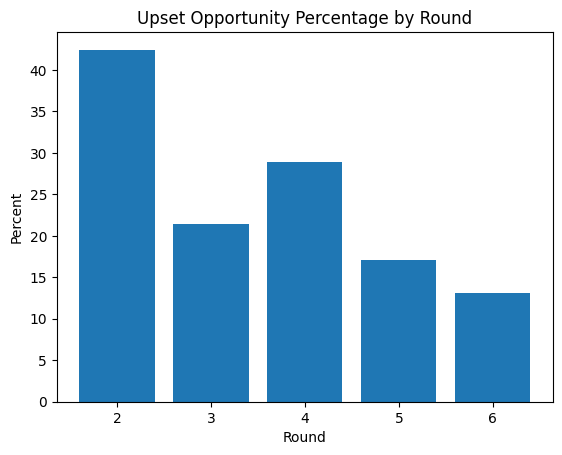

In [981]:
c3_1 = df_round_3["WSEED"] - df_round_3["LSEED"] > 4
c3_2 = df_round_3["LSEED"] - df_round_3["WSEED"] > 4
c4_1 = df_round_4["WSEED"] - df_round_4["LSEED"] > 4
c4_2 = df_round_4["LSEED"] - df_round_4["WSEED"] > 4
c5_1 = df_round_5["WSEED"] - df_round_5["LSEED"] > 4
c5_2 = df_round_5["LSEED"] - df_round_5["WSEED"] > 4
c6_1 = df_round_6["WSEED"] - df_round_6["LSEED"] > 4
c6_2 = df_round_6["LSEED"] - df_round_6["WSEED"] > 4

df_round_3_upsets = df_round_3[c3_1]
df_round_3_upset_avoided = df_round_3[c3_2]
df_round_3_upset_oppos = df_round_3[c3_1 | c3_2]
df_round_3_non_upsets = df_round_3[~c3_1 & ~c3_2]

df_round_4_upsets = df_round_4[c4_1]
df_round_4_upset_avoided = df_round_4[c4_2]
df_round_4_upset_oppos = df_round_4[c4_1 | c4_2]
df_round_4_non_upsets = df_round_4[~c4_1 & ~c4_2]

df_round_5_upsets = df_round_5[c5_1]
df_round_5_upset_avoided = df_round_5[c5_2]
df_round_5_upset_oppos = df_round_5[c5_1 | c5_2]
df_round_5_non_upsets = df_round_5[~c5_1 & ~c5_2]

df_round_6_upsets = df_round_6[c6_1]
df_round_6_upset_avoided = df_round_6[c6_2]
df_round_6_upset_oppos = df_round_6[c6_1 | c6_2]
df_round_6_non_upsets = df_round_6[~c6_1 & ~c6_2]

keys = ["2", "3", "4", "5", "6"]

# Upset Opportunites per Round by Percentage
opp_per = [(len(df_round_2_upset_oppos) - 304) * 100 / (len(df_round_2) - 304)]
opp_per.append(len(df_round_3_upset_oppos) * 100 / len(df_round_3))
opp_per.append(len(df_round_4_upset_oppos) * 100 / len(df_round_4))
opp_per.append(len(df_round_5_upset_oppos) * 100 / len(df_round_5))
opp_per.append(len(df_round_6_upset_oppos) * 100 / len(df_round_6))

# Total Amount of Opportunities
opp_tot = [len(df_round_2_upset_oppos) - 304]
opp_tot.append(len(df_round_3_upset_oppos))
opp_tot.append(len(df_round_4_upset_oppos))
opp_tot.append(len(df_round_5_upset_oppos)) 
opp_tot.append(len(df_round_6_upset_oppos))

plt.bar(keys, opp_per)
plt.title("Upset Opportunity Percentage by Round")
plt.xlabel("Round")
plt.ylabel("Percent")
plt.show()

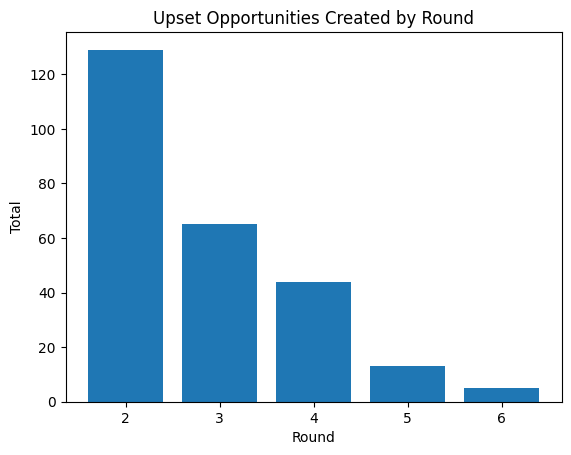

In [971]:
plt.bar(keys, opp_tot)
plt.title("Upset Opportunities Created by Round")
plt.xlabel("Round")
plt.ylabel("Total")
plt.show()

The amount of upset opportunities created in the Second Round is more that the ones created in the following rounds combined. That should make sense since 16 games are played in Round 2 and 8 + 4 + 2 + 1 or 15 games are played in the following rounds. But enough of that, let us do our usual EDA.

#### The Scope

In [982]:
df_r3_6_upsets = pd.concat([df_round_3_upsets, df_round_4_upsets, df_round_5_upsets, df_round_6_upsets])
df_r3_6_upset_avioded = pd.concat([df_round_3_upset_avoided, df_round_4_upset_avoided, df_round_5_upset_avoided, df_round_6_upset_avoided])
df_r3_6_upset_oppos = pd.concat([df_round_3_upset_oppos, df_round_4_upset_oppos, df_round_5_upset_oppos, df_round_6_upset_oppos])
df_r3_6_non_upsets = pd.concat([df_round_3_non_upsets, df_round_4_non_upsets, df_round_5_non_upsets, df_round_6_non_upsets])

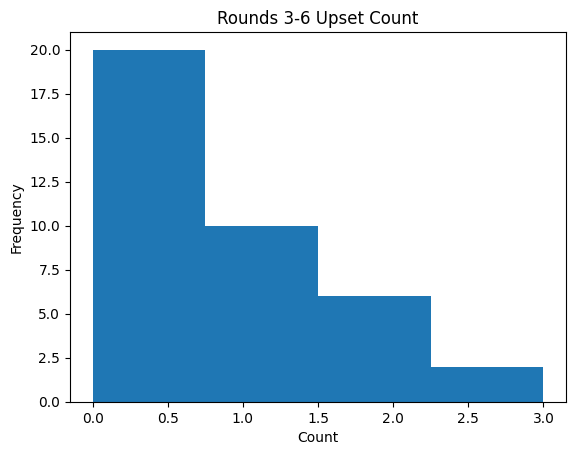

In [1070]:
r3_6_upsets_per_yr = df_r3_6_upsets.groupby("YEAR")["UPSET"].count()
r3_6_upset_avoided = df_r3_6_upset_avioded.groupby("YEAR")["UPSET"].count()
r3_6_upset_oppos_per_yr = df_r3_6_upset_oppos.groupby("YEAR")["UPSET"].count()

lis_upset = []
lis_avoid = []
lis_oppos = []

for i in range(r3_6_upsets_per_yr.index[0], r3_6_upsets_per_yr.index[-1]):
    if i == 2020:
        continue
    if i not in r3_6_upsets_per_yr.index:
        lis_upset.append(i)
    if i not in r3_6_upset_avoided.index:
        lis_avoid.append(i)
    if i not in r3_6_upset_oppos_per_yr.index:
        lis_oppos.append(i)
    
    
    

a_upset = pd.DataFrame([0 for j in range(len(lis_upset))], index = lis_upset, columns = ["UPSET"])
a_avoid = pd.DataFrame([0 for j in range(len(lis_avoid))], index = lis_avoid, columns = ["UPSET"])
a_oppos = pd.DataFrame([0 for j in range(len(lis_oppos))], index = lis_oppos, columns = ["UPSET"])

r3_6_upsets_per_yr = r3_6_upsets_per_yr.to_frame()
r3_6_upsets_per_yr = pd.concat([r3_6_upsets_per_yr, a_upset])
r3_6_upsets_per_yr = r3_6_upsets_per_yr.squeeze()

r3_6_upset_avoided = r3_6_upset_avoided.to_frame()
r3_6_upset_avoided = pd.concat([r3_6_upset_avoided, a_avoid])
r3_6_upset_avoided = r3_6_upset_avoided.squeeze()

r3_6_upset_oppos_per_yr = r3_6_upset_oppos_per_yr.to_frame()
r3_6_upset_oppos_per_yr = pd.concat([r3_6_upset_oppos_per_yr, a_oppos])
r3_6_upset_oppos_per_yr = r3_6_upset_oppos_per_yr.squeeze()

plt.hist(r3_6_upsets_per_yr, bins = 4)
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.title("Rounds 3-6 Upset Count")
plt.show()

Yeah, not a lot. But let us see how the seeds did in these opportunities.

In [1302]:
l = []
for i in range(6, 16):
    l.append({"Seed": i, "Wins": 0, "Losses": 0, 
              "R3Wins": 0, "R3Losses": 0, "R4Wins": 0,
              "R4Losses": 0, "R5Wins": 0, "R5Losses": 0,
              "R6Wins": 0, "R6Losses": 0})
    
r3_6_records = pd.DataFrame(l)
r3_6_records = r3_6_records.set_index("Seed")

for i in range(len(df_r3_6_upsets)):
    round = df_r3_6_upsets.iloc[i, 1]
    r3_6_records.loc[df_r3_6_upsets.iloc[i, 2], "Wins"] += 1
    r3_6_records.loc[df_r3_6_upsets.iloc[i, 2], F"R{round}Wins"] += 1

for i in range(len(df_r3_6_upset_avioded)):
    round = df_r3_6_upset_avioded.iloc[i, 1]
    r3_6_records.loc[df_r3_6_upset_avioded.iloc[i, 5], "Losses"] += 1
    r3_6_records.loc[df_r3_6_upset_avioded.iloc[i, 5], F"R{round}Losses"] += 1
    
r3_6_records["Win Pct"] = r3_6_records["Wins"] / (r3_6_records["Wins"] + r3_6_records["Losses"])
r3_6_records

,Wins,Losses,R3Wins,R3Losses,R4Wins,R4Losses,R5Wins,R5Losses,R6Wins,R6Losses,Win Pct
Seed,,,,,,,,,,,
6,3,9,0,0,2,8,0,0,1,1,0.250000
7,1,6,0,0,0,4,1,2,0,0,0.142857
8,7,6,0,0,3,3,3,1,1,2,0.538462
9,4,5,2,2,2,2,0,1,0,0,0.444444
10,5,18,4,9,1,8,0,1,0,0,0.217391
11,7,23,3,15,4,4,0,4,0,0,0.233333
12,0,22,0,20,0,2,0,0,0,0,0.000000
13,0,5,0,5,0,0,0,0,0,0,0.000000
14,0,1,0,1,0,0,0,0,0,0,0.000000


Let us break it down seed-by-seed:

- 6: The only scenario where the 6th seed can be the upsetter is when they face the 1 seed. They cannot face the 1 seed in Round 3, so that explains why there is no data in the R3 columns. In Round 4, there have been 10 scenarios where the 6 seed faced the 1 seed and only two 6 seeds have successfully completed the upset. No 6 seed has faced the 1 seed in Round 5, and both the 6 and 1 seed are split in Round 6. 

- 7: Can only face the 1 and 2 seeds for an upset opportunity. The 7 seed can only face the 2 seed in Rounds 2, 5, and 6, and can only face the 1 seed in Rounds 4 - 6. I would also preface by saying it is implied that any seed can face any seed in Rounds 5 and 6. The 7 seed unfortunately has awful luck against the 1 seed in Round 4 and can somewhat show up in Round 5. No data was found on Round 6, so we move on.

- 8: Can face the 2 and 3 seed every round. Seems like these guys have great luck as they are the only seed to have an above 500 record against the heavy favorite. We can definitely count on them to upset in Round 5 while coinflipping in the other rounds. 

- 9: Up to 4. Like the 8 seed, but with a little less luck. 

- 10: Up to 5. Awful performances by this seed in Rounds 3 and up. Though they have the potential to make it far, many have fallen short of the Final Four with a 1-8 record in the Elite 8. That does not mean they should not be taken seriously however, with 5 upsets, maybe we should keep an eye on them.

- 11: Up to 6. This is probably the most intriguing one only because I can distinctly remember the teams that represented them. 2018 Loyola Chicago (Ill) where they made nail biters after nail biters and 2021 UCLA who had to play in Round 0 before making there Final Four run only to have a buzzer beater 3 stop their Cinderella run. Beside those teams, the 11 seed has bad luck post Round 2 like the 10 seed, especially in Round 3. When we get to Round 4, you might want to start questioning their opponent. 

- 12: If Round 2 was not their snap back to reality, then Round 3 definitely is. 0-20 in Round 3 and at least 2 of them made to Round 4 on a non-upset only to be wrecked. Do not count on the 12 seed to do huge things at this point.

- 13 and 14. 6 combined appearances from these two. No Elite 8 upset opportunities. Do these seeds even make it to Round 3?

- 15: I can vividly remember when 15 seeded St. Peter's upsetted 3 seeded Purdue in Round 3 of the 2022 March Madnesss. Purdue is just awful. 

#### Over the Years

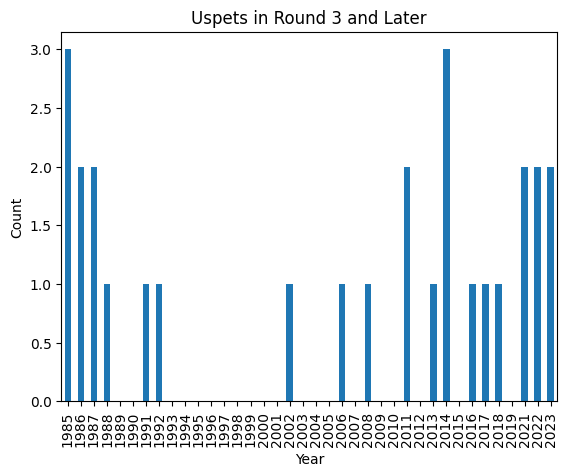

In [1072]:
r3_6_upsets_per_yr.sort_index().plot(kind = 'bar', title = "Uspets in Round 3 and Later")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

Funny, we have this dead space of no upsets from 1993 to 2001, and for the last three years, we have had more than one upset. How does this compare to the opportunities they have?

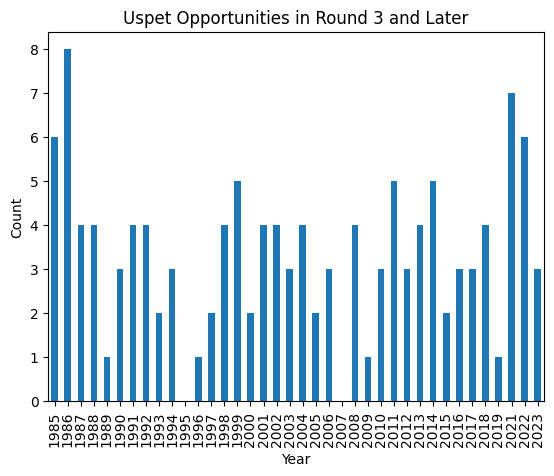

In [1073]:
r3_6_upset_oppos_per_yr.sort_index().plot(kind = 'bar', title = "Uspet Opportunities in Round 3 and Later")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

So every year has at least one opportunity with the exception of two years. Now we compare percentages.

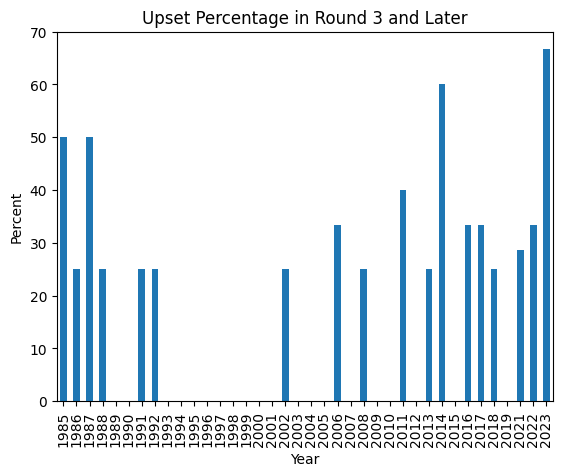

In [1075]:
r3_6_upset_percentage =  r3_6_upsets_per_yr * 100 / r3_6_upset_oppos_per_yr
r3_6_upset_percentage.sort_index().plot(kind = 'bar', title = "Upset Percentage in Round 3 and Later")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.show()

Interesting, even though 2023 did not have a lot of upsets nor opportunities, that year did have the best success rate out of all the years, including the upset heavy years of 1985, 2021, and 2022. Is there a correlation between upsets and upsets avoided?

/Users/janjacob/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


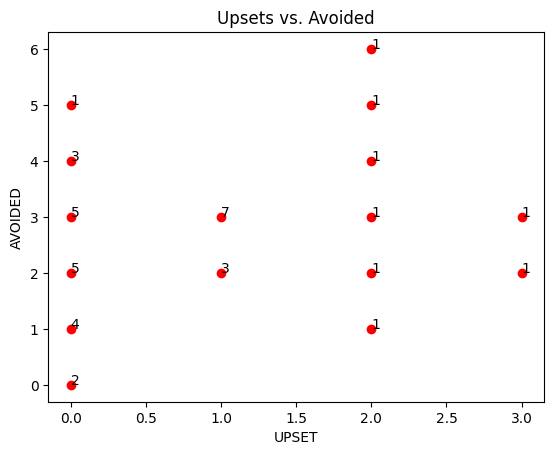

,UPSET,AVOIDED
UPSET,1.000000,0.248472
AVOIDED,0.248472,1.000000


In [1153]:
x1 = r3_6_upsets_per_yr.sort_index().to_frame()
x2 = r3_6_upset_avoided.sort_index().to_frame()
x2 = x2.rename(columns = {"UPSET": "AVOIDED"})
x3 = pd.concat([x1, x2], axis = 1)

x3.plot.scatter(x = "UPSET", y = "AVOIDED")
plt.title("Upsets vs. Avoided")

# Let us also add in the frequency of each point
lis = [(r3_6_upsets_per_yr[i], r3_6_upset_avoided[i]) for i in range(1985, 2024) if i != 2020]
s = set(lis)
d = {}
for i in list(s):
    d[i] = lis.count(i)

X = [i[0] for i in d.keys()] 
Y = [i[1] for i in d.keys()]
plt.plot(X, Y, 'ro')
for i in d.keys():
    plt.annotate(d[i], xy = i)

plt.show()
x3.corr(method = "pearson")

**It is nice to have maybe 3 upset opportunities in Rounds 3 and up. It is also probably a good idea to have those opportunities be converted into upsets, and those upsets should not come from seeds 11 and up.**

## Names EDA

Finally, let us look at some colleges that upset and get upsetted frequently.

In [1373]:
upsetted_by_name = df_upsets.groupby("LTEAM")["LTEAM"].count()
upsetted_by_name.sort_values(ascending = False)
upsetted_by_name

LTEAM
Alabama            5
Arizona           10
Auburn             1
Baylor             3
Boston College     1
                  ..
Washington         1
West Virginia      3
Wichita State      3
Wisconsin          9
Xavier             4
Name: LTEAM, Length: 89, dtype: int64

Now this is most likely the case where percentages will tell a better story. Kansas and Wisconsin both are upset favorites, but one of them raises a big red flag.

In [1374]:
df_upset_avoided = df_upset_potential[df_upset_potential["UPSET"] == False]
no_upsets = df_upset_avoided.groupby("WTEAM")["WTEAM"].count()
no_upsets

WTEAM
Alabama               11
Alabama-Birmingham     1
Arizona               35
Arizona State          3
Arkansas              20
                      ..
Washington State       2
West Virginia         11
Wichita State          1
Wisconsin             16
Xavier                13
Name: WTEAM, Length: 100, dtype: int64

In [1436]:
team_upset_records = upsetted_by_name.to_frame().join(no_upsets.to_frame(), how = "outer")
team_upset_records = team_upset_records.fillna(0)
team_upset_records = team_upset_records.rename(columns = {"LTEAM": "Upsets", "WTEAM": "Wins"})
team_upset_records["Upsets"] = team_upset_records["Upsets"].astype("int")
team_upset_records["Wins"] = team_upset_records["Wins"].astype("int")
team_upset_records["Upset/Win Pct"] = team_upset_records["Upsets"] / (team_upset_records["Wins"] + team_upset_records["Upsets"])
team_upset_records.sort_values("Upsets", ascending = False).head(8)

,Upsets,Wins,Upset/Win Pct
Kansas,11,62,0.150685
Arizona,10,35,0.222222
Purdue,9,20,0.310345
Wisconsin,9,16,0.360000
Virginia,8,15,0.347826
Duke,8,69,0.103896
Oklahoma,8,25,0.242424
Ohio State,7,21,0.250000


This will look weird considering that the Upset column is first (which is why having upset percentage instead of win percentage looks unusual), but context matters. It seems like Wisconsin has a much higher upset rate (.36) than Kansas (.15). Now let us compare some other stats. We would also like to find out what percentage of upsets come from losses too.

In [1437]:
team_upset_records["Total Losses"] = 0
for i in team_upset_records.index:
    team_upset_records.loc[i, "Total Losses"] = len(df_results[df_results["LTEAM"] == i])
    
team_upset_records["Upset/Loss Pct"] = team_upset_records["Upsets"] / team_upset_records["Total Losses"]
team_upset_records.sort_values("Upsets", ascending = False).head(8)

,Upsets,Wins,Upset/Win Pct,Total Losses,Upset/Loss Pct
Kansas,11,62,0.150685,34,0.323529
Arizona,10,35,0.222222,33,0.303030
Purdue,9,20,0.310345,29,0.310345
Wisconsin,9,16,0.360000,24,0.375000
Virginia,8,15,0.347826,19,0.421053
Duke,8,69,0.103896,31,0.258065
Oklahoma,8,25,0.242424,27,0.296296
Ohio State,7,21,0.250000,22,0.318182


For clarity, the *Upset/Win Pct* column denotes wins against upset potential teams. The *Upset/Loss Pct* column denotes the percentage of upsets that come from losses. Finally, is there a correlation between these two columns? Let us do some Linear Regression

/Users/janjacob/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


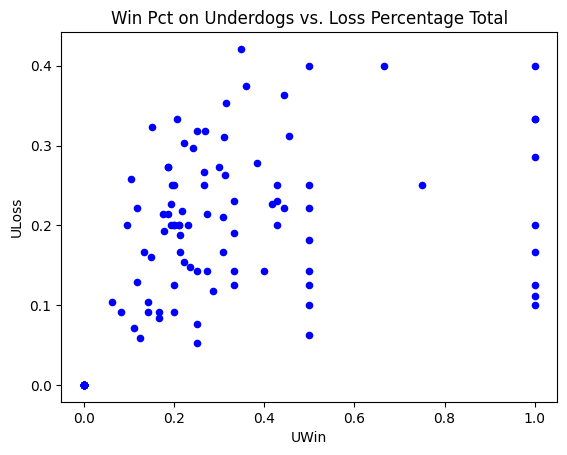

In [1490]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# We will need a coopy since we will have to rename some columns
copy = team_upset_records.copy()
copy = copy.rename(columns = {"Upset/Loss Pct": "ULoss", "Upset/Win Pct": "UWin"})

m = ols('ULoss ~ UWin', copy).fit()

copy.plot.scatter(x = "UWin", y = "ULoss", c = 'blue')
plt.title("Win Pct on Underdogs vs. Loss Percentage Total")
plt.show()

It looks like a typical scatterplot, but it does have some oddities. One, we have a line of plots towards the right which denotes the teams that have gotten upset and every opportunity. This can be misleading since most of the teams probably have only been in one upset opportunity. We also have many observations at the origin, i.e. teams that have never been upsetted. Let us look at some other useful data.

In [1485]:
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  ULoss   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     33.67
Date:                Wed, 24 May 2023   Prob (F-statistic):           6.73e-08
Time:                        11:14:59   Log-Likelihood:                 96.669
No. Observations:                 109   AIC:                            -189.3
Df Residuals:                     107   BIC:                            -184.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1102      0.014      7.742      0.0

Funny, it should make sense to have a 0 percent upset loss rate when you have a 0 percent upset win rate, but the summary says that you have an 11 percent upset loss rate. This rate increases by 2.1 percent for each .1 increase in upset win percentage. With an $R^{2}$ of .239, we can say that 23.9 percent of the variation of Upset Loss Percentage is explained by Upset Win Percentage.

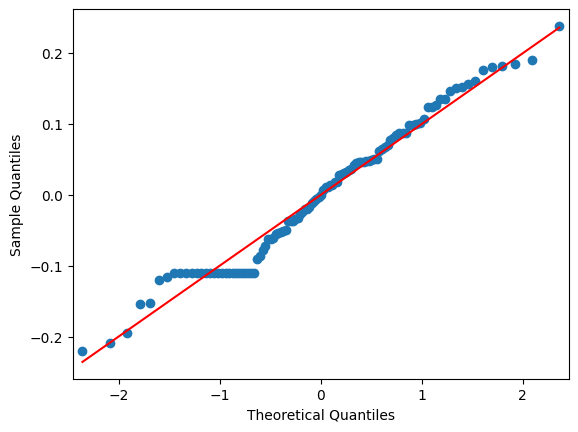

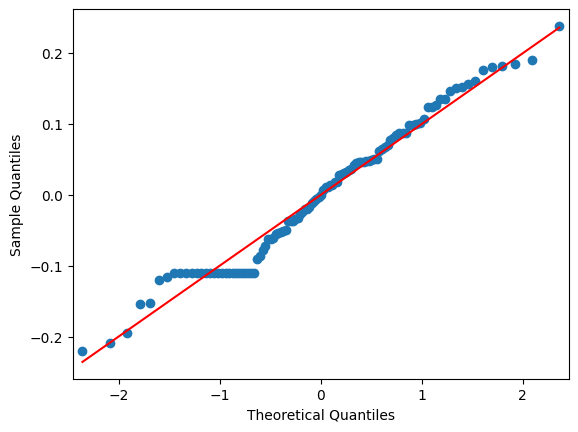

In [1486]:
sm.qqplot(m.resid, line = 's')

We see that the residuals follow the red line except for one section where we see a straight horizontal line at around -1.5 to -0.5 on the x-axis. Let us run this again but instead dropping all values whose Upset Win Percentage is 100 and teams that have never been upsetted before.

/Users/janjacob/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


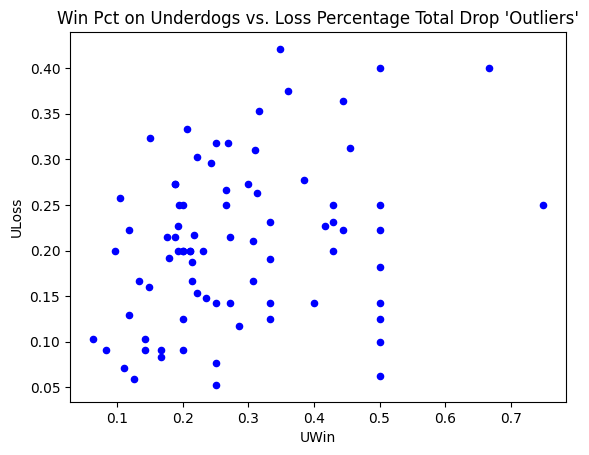

In [1513]:
copy_drop = copy[copy["Upsets"] != 0]
copy_drop = copy_drop[copy_drop["UWin"] != 1.0]

m1 = ols('ULoss ~ UWin', copy_drop).fit()

copy_drop.plot.scatter(x = "UWin", y = "ULoss", c = 'blue')
plt.title("Win Pct on Underdogs vs. Loss Percentage Total Drop 'Outliers'")
plt.show()

In [1505]:
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:                  ULoss   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     7.824
Date:                Wed, 24 May 2023   Prob (F-statistic):            0.00649
Time:                        11:19:00   Log-Likelihood:                 85.818
No. Observations:                  80   AIC:                            -167.6
Df Residuals:                      78   BIC:                            -162.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1534      0.021      7.147      0.0

Some notable differences. One, the interpretation of our coefficients make sense. Two, we have a much lower $R^{2}$ value; it is now 9%.

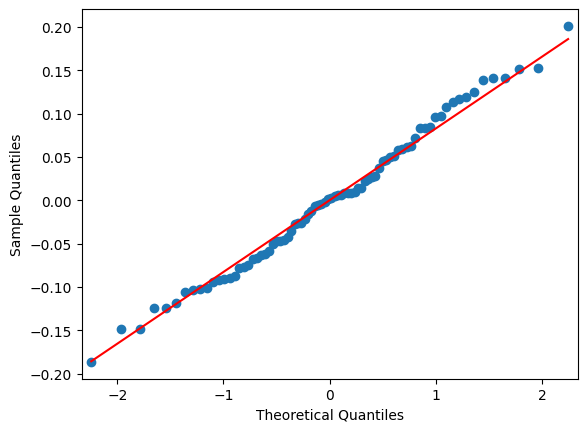

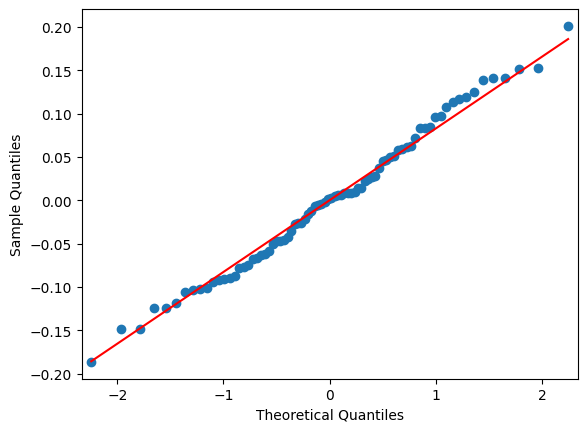

In [1511]:
sm.qqplot(m1.resid, line = 's')

At least we got rid of that weird section in our QQ-plot.

**From the looks of the analysis, it might be better to look at this more recently. Historically, there are teams that we should not trust in Wisconsin or Arizona, but today, Purdue has something to say about that.**

### How to Predict the Perfect Bracket

Let us record real quick our bolded statements.

We should have around 28-32 avoided upsets. As for upsets, we should definitely have around 3-6 upsets. For the first round, we should have at least 1 upset from the 11, 12, and maybe the 13 seed. The rest should be either another 11 and/or 12 upset or a 13, 14 and/or 15 upsets. But for a more recent approach, picking upsets really depends on the 11 seeds usually and the 15 seeds. For Round 2, there is really nothing out of the ordinary other than the fact that 15 seeds have a better chance to upset the 7 seed than the 10. Do not count on Round 1 upsetters to do the same thing. For Rounds 3 and up, it is okay to have some opportunities. If there were upsets, make sure they come from Seeds 6-10. As for names, do not pick Purdue.

There is a reason why nobody has created a perfect bracket through the Second Round let alone the whole thing. That is why this project will aim for perfection first while landing on close enough.